In [1]:
!pip install monai pydicom gdcm pylibjpeg pylibjpeg-libjpeg
!pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 80.5 MB/s eta 0:00:00


In [2]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-04-01 12:04:21.225757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 12:04:21.225871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 12:04:21.364441: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report
import cv2

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

2024-04-01 12:05:01.317943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 12:05:01.318006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 12:05:01.319444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.13
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.12.0
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://do

In [4]:
import pandas as pd
import pydicom
from torchvision import transforms
import pickle


from sklearn.model_selection import train_test_split

# Timing utility
from timeit import default_timer as timer
from tqdm import tqdm

import torch
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import seaborn as sn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


print("all imported")

set_determinism(seed=0)

all imported


In [5]:
# diseases = ['Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia']

diseases = ['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia']
# decided on the basis of frequency of occurence of individual diseases in images.

# Drop columns not in the list
columns_to_keep = diseases.copy()
columns_to_keep.append('image_id')

print(diseases)
print(columns_to_keep)

['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia']
['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia', 'image_id']


In [6]:
## From past experiments ##
corrupted_ids = [
    '99905540dca6c8ece8e07ace8362b679',
    'd22b70c6029843ebff15c7e0d0c4b259',
]

In [7]:
# some helper functions:-
def delete_corrupted(df, corrupted_ids):
    df = df[~df['image_id'].isin(corrupted_ids)]
    return df

def delete_columns(df, columns_to_keep=columns_to_keep, root_folder='/train'):
    columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
#     print("COLUMNS to drop:", columns_to_drop)
    df.drop(columns=columns_to_drop, inplace=True)
    print(f"Deleted columns from {root_folder.split('/')[-1]} folder")
    return df

def change_dtype(df, To, columns=diseases, root_folder='/train'):
    # Convert data types of specified columns
    for col in columns:
        if col in df.columns:
            try:
                df[col] = df[col].astype(To)
            except ValueError:
                print(f"Unable to convert column '{col}' to data type '{To}'")
    print(f"Changed datatypes of columns of {root_folder.split('/')[-1]} folder")
    return df

def retain_single_disease_examples(df, columns, split='train'):

    filtered_df = df[df[columns].eq(1.0).sum(axis=1) == 1]
    
    print(f"Number of rows removed in {split} to get multiclass classification data:", len(df) - len(filtered_df))
    return filtered_df

    
def remove_all_zeros(df, diseases=diseases, root_folder='/train'):
    # Remove rows where all values are 0 in the disease labels
    df = df[(df[diseases] != 0).any(axis=1)]
    df.reset_index(drop=True, inplace=True)
    return df
    
    
def add_file_path_column(df, root_folder='/train'):
    df['file_path'] = df['image_id'].apply(lambda x: os.path.join(root_folder, f"{x}.npy"))
    print(f"Added file_path column to {root_folder.split('/')[-1]} folder")
    return df

In [8]:
# Loading the original csv files
train_data = pd.read_csv('/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/image_labels_train.csv')
test_data = pd.read_csv('/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/image_labels_test.csv')

# delete corrupted images
train_data = delete_corrupted(train_data, corrupted_ids)


disease_labels = list(train_data.columns)[2:]
print("ORIGINAL disease labels:", disease_labels, len(disease_labels))

# Count occurrences of each class
class_counts = train_data.iloc[:, 2:].sum()
print("TOTAL train Individual class counts:-\n", class_counts)
print('-'*100)

class_counts = test_data.iloc[:, 2:].sum()
print("TOTAL test Individual class counts:-\n", class_counts)
print('-'*100)


train_data = change_dtype(train_data, To='int', columns=diseases, root_folder='train')
train_data = delete_columns(train_data, columns_to_keep=columns_to_keep, root_folder='train')
train_data = retain_single_disease_examples(train_data, diseases, split='train')
train_data = remove_all_zeros(train_data, diseases=diseases, root_folder='train')
train_data = add_file_path_column(train_data, root_folder='/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-512-clahe/train')
print('-'*100)

test_data = change_dtype(test_data, To='int', columns=diseases, root_folder='test')
test_data = delete_columns(test_data, columns_to_keep=columns_to_keep, root_folder='test')
test_data = retain_single_disease_examples(test_data, diseases, split='test')
test_data = remove_all_zeros(test_data, diseases=diseases, root_folder='test')
test_data = add_file_path_column(test_data, root_folder='/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-512-clahe/test')
print('-'*100)


# Split 10% of the training data as validation data, with random_state=42, for reproducibility
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# reducing the size (comment this)
# train_data = train_data.head(500)
# val_data = val_data.head(500)
# test_data = test_data.head(500)


# Resetting the index, very important
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)


# collecting & storing the labels separately
train_paths = train_data['file_path'].values
train_labels = train_data[diseases].values

val_paths = val_data['file_path'].values
val_labels = val_data[diseases].values

test_paths = test_data['file_path'].values
test_labels = test_data[diseases].values


print("length of train:", len(train_data))
print("length of val:", len(val_data))
print("length of test:", len(test_data))

ORIGINAL disease labels: ['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia', 'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema', 'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor', 'Lung tumor'] 15
TOTAL train Individual class counts:-
 No finding                  5141.0
Bronchitis                   842.0
Brocho-pneumonia             545.0
Other disease                412.0
Bronchiolitis                497.0
Situs inversus                11.0
Pneumonia                    392.0
Pleuro-pneumonia               6.0
Diagphramatic hernia           3.0
Tuberculosis                  14.0
Congenital emphysema           2.0
CPAM                           5.0
Hyaline membrane disease      19.0
Mediastinal tumor              8.0
Lung tumor                     5.0
dtype: float64
----------------------------------------------------------------------------------------------------
TOTAL test Individual c

In [9]:
train_data.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Pneumonia,file_path
0,8e17f30368fdde9f53da6c7f30c99a2d,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
1,6821bc0bf5bdfd14871c202024b8e3e7,0,0,0,0,0,1,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
2,ba427884c7e125566c7b135110233f37,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
3,436f304bafe80d5538b3ff20e166f371,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
4,9546374ef593de84b449136d4bfb3a11,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...


In [10]:
val_data.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Pneumonia,file_path
0,e0963255a932923791b1649d0dbe7808,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
1,28d022ed74a2cafe67c2785f73a9f8eb,0,0,0,1,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
2,6ff943d2be69df923ef737b042ca321f,0,1,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
3,c9230ab47911f78f6d88689fb631307f,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
4,d4d8ae47bf9fcc5fb66cd297a15b32c5,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...


In [11]:
test_data.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Pneumonia,file_path
0,d7e71a052a753c3f2f3e317d60177bec,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
1,e64d9421e78c82b5c104021a6c1b4e67,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
2,8a12a4352a866aaea4691dd27a99c7ae,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
3,30d6a0843a9792168fdc456c17a9028c,0,0,0,0,0,1,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
4,f22138be08a24e79cf07f6207341e5f5,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...


In [12]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import matplotlib.pyplot as plt
%matplotlib inline


def read_xray(path, voi_lut = True, fix_monochrome = True, apply_clahe=True, clipLimit=2.0, tileGridSize=(8,8)):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
#     data = data.astype(np.float32)
#     data = (data * 255.0).astype(np.float32) # no need for this I think 

    if apply_clahe:
        data = apply_clahe_to_image(data, clipLimit=clipLimit, tileGridSize=tileGridSize)
        
    return data



def apply_clahe_to_image(image, clipLimit=2.0, tileGridSize=(8,8)):
    # Convert image to uint16
    image = (image * 65535).astype(np.uint16)
    
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    
    # Apply CLAHE
    clahe_image = clahe.apply(image)
    
    # Convert image back to float32 in range [0, 1]
    clahe_image = clahe_image.astype(np.float32) / 65535.0
    
    return clahe_image



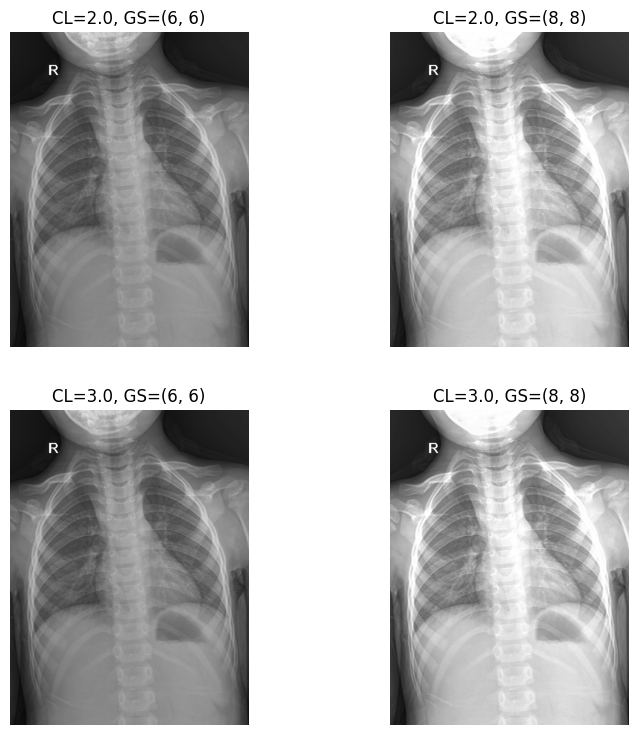

In [13]:
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes[i // cols, i % cols]
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.show()


# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/000295d6ff55184f19d99e95f93c3a55.dicom'
# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/002cf1f4cba98648335843f21756ee36.dicom'
# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/0119beca31970c7d5293316a515d7ee9.dicom'
# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/01b9c6193cfd9c247cad1b843a95aca7.dicom'
path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/021405230e5a837a061b9c87f9d2565b.dicom'

clipLimits = [2.0, 3.0]
tileGridSizes = [(6,6),(8,8)]
images = []
titles = []

for clipLimit in clipLimits:
    for tileSize in tileGridSizes:
        images.append(read_xray(path, clipLimit=clipLimit, tileGridSize=tileSize))
        titles.append(f"clipLimit={clipLimit}, tileGridSize={tileSize}")
    
titles = [f"CL={clipLimit}, GS={tileSize}" for clipLimit in clipLimits for tileSize in tileGridSizes]
plot_images(images, titles, len(clipLimits), len(tileGridSizes))

In [14]:
train_image_files = [
    os.path.join('/', train_paths[i]) for i in range(len(train_paths))
]
print(len(train_image_files))

val_image_files = [
    os.path.join('/', val_paths[i]) for i in range(len(val_paths))
]
print(len(val_image_files))

test_image_files = [
    os.path.join('/', test_paths[i]) for i in range(len(test_paths))
]
print(len(test_image_files)) 

6713
746
1351


image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)


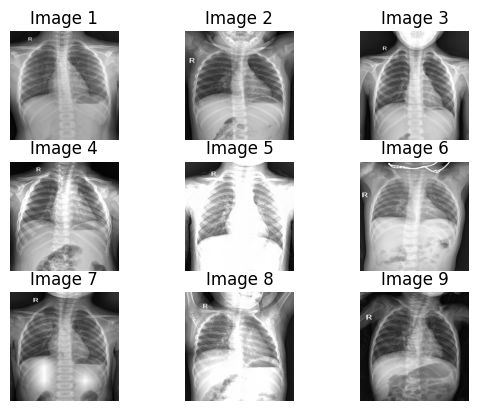

In [15]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_image_files is a list of DICOM file paths
# Example:
# train_image_files = ["path/to/dicom/file1.dcm", "path/to/dicom/file2.dcm", ...]

for i, k in enumerate(np.random.randint(len(train_image_files), size=9)):
#     dicom_image = pydicom.dcmread(train_image_files[k])
    
    # Typecast to float64
#     float64_image_array = dicom_image.pixel_array.astype(np.float64)
    
    float64_image_array = np.load(train_image_files[k])
    print("image_shape:", float64_image_array.shape)
    
    # Visualization using Matplotlib
    plt.subplot(3, 3, i + 1)
    plt.imshow(float64_image_array, cmap='gray')  # Assuming grayscale DICOM images
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.show()


In [16]:
BATCH_SIZE = 8
IMAGE_SIZE = (224,224) # the size to which the image would be resized before passing to the model
num_classes = len(diseases) 

print("BATCH_SIZE: ", BATCH_SIZE) 
print("IMAGE_SIZE: ", IMAGE_SIZE) 
print("num_classes:", num_classes)

BATCH_SIZE:  8
IMAGE_SIZE:  (224, 224)
num_classes: 6


In [17]:
from monai.transforms import Compose, Lambda, EnsureChannelFirst, ScaleIntensity,\
 RandRotate, RandFlip, RandZoom, RandSpatialCrop, RandRotate90, ResizeWithPadOrCrop, Resize

def load_tensor(data):
    # Convert the data to a supported data type (e.g., float32)
    return data.astype(np.float32)


train_transforms = Compose(
    [
#         LoadImage(image_only=True), 
        Lambda(load_tensor),
        EnsureChannelFirst(channel_dim=0),
#         RandSpatialCrop(IMAGE_SIZE[0],IMAGE_SIZE[1]), random_size=False),
        Resize(spatial_size=(IMAGE_SIZE[0],IMAGE_SIZE[1])),
#         ResizeWithPadOrCrop(spatial_size=IMAGE_SIZE),
#         RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ScaleIntensity(),
#         RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True), # highly sensitive data
#         RandFlip(spatial_axis=0, prob=0.5),  # some abnormalities may be localized in a particular side
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [
#         LoadImage(image_only=True),
        Lambda(load_tensor),
        EnsureChannelFirst(channel_dim=0),
#         ResizeWithPadOrCrop(spatial_size=IMAGE_SIZE),
        Resize(spatial_size=(IMAGE_SIZE[0],IMAGE_SIZE[1])),

        ScaleIntensity(),

    ]
)

# y_pred_trans = Compose([Activations(softmax=True)])
# y_trans = Compose([AsDiscrete(to_onehot=num_class)])

y_pred_trans = Compose([Activations(sigmoid=True)]) # for multi-label classfication
y_trans = Compose([AsDiscrete(threshold_values=True)])


In [18]:
class VINDR_PCXR_Dataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, in_chans=1, transforms=None):
        self.paths = paths
        self.labels = labels
        self.transforms = transforms
        self.target_size = IMAGE_SIZE
        self.in_chans = in_chans
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
#         print(index)
        img_path = self.paths[index]
#         print(img_path, index)
        labels = self.labels[index]
#         labels = torch.tensor(labels.values, dtype=torch.long)  # Use dtype=torch.long
        
#         dicom = pydicom.read_file(img_path)
#         image = dicom.pixel_array.astype(np.float32)
#         image = read_xray(img_path, voi_lut = True, fix_monochrome = True, apply_clahe=True, clipLimit=2.0, tileGridSize=(6,6))
        
        image = np.load(img_path)
    
        # Expand the dimensions to add a channel dimension
        image = np.expand_dims(image, axis=0)
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, np.argmax(labels) # return just the index of the disease (instead of the one hot vector)


train_ds = VINDR_PCXR_Dataset(train_paths, train_labels, in_chans=1, transforms=train_transforms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_ds = VINDR_PCXR_Dataset(val_paths, val_labels, in_chans=1, transforms=val_transforms)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4)

test_ds = VINDR_PCXR_Dataset(test_paths, test_labels, in_chans=1, transforms=val_transforms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4)

print("No. of TRAIN batches:", len(train_loader))
print("No. of VAL batches:", len(val_loader))
print("No. of TEST batches:", len(test_loader))


No. of TRAIN batches: 840
No. of VAL batches: 94
No. of TEST batches: 169


In [19]:
from thop import profile
from thop import clever_format
import torch

def display_params_flops(model):
    #params
    num_params = sum(p.numel() for p in model.parameters())
    num_params_millions = num_params / 1e6
    print(f"Number of parameters in millions: {num_params_millions:.2f} M")

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    num_params_millions = num_params / 1e6
    print(f"Number of trainable parameters in millions: {num_params_millions:.2f} M")


    #FLOPS
    input_size = (1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1])  


    # Move the model to GPU if available
    if torch.cuda.is_available():
        model = model.cuda()

    # Use thop.profile to count FLOPs
    input_tensor = torch.randn(*input_size)
    if torch.cuda.is_available():
        input_tensor = input_tensor.cuda()
    flops, params = profile(model, inputs=(input_tensor,))

    # Convert FLOPs to gigaFLOPs and format the results
    flops, params = clever_format([flops, params], "%.2f")
    print(f"FLOPs: {flops}, Params: {params}")
    

### Model Definition

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models

from torch import nn
from timm import create_model


class SwinTransformerModel(nn.Module):
    def __init__(self, num_classes, fine_tune=False):
        super(SwinTransformerModel, self).__init__()
        self.swin = create_model(
            'swin_large_patch4_window7_224.ms_in22k', 
            pretrained=True,
            num_classes=num_classes,
            in_chans=1
        )
        
        if not fine_tune:
            for param in self.swin.parameters():
                param.requires_grad = False
            
            for param in self.swin.head.parameters():
                param.requires_grad = True
        

    def forward(self, x):
        x = self.swin(x)
        return x
    
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinTransformerModel(num_classes, fine_tune=False)
model.to(device)

# print(model)
print()

x = torch.randn(1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)


output = model(x)
print("Model output's shape:", output.shape)
print(output) # logits 
display_params_flops(model)

model.safetensors:   0%|          | 0.00/916M [00:00<?, ?B/s]


Model output's shape: torch.Size([1, 6])
tensor([[-0.1523,  0.4273,  0.0574,  0.6546,  0.4203,  0.5721]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Number of parameters in millions: 195.00 M
Number of trainable parameters in millions: 0.01 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPs: 34.06G, Params: 194.90M


In [21]:
model = SwinTransformerModel(num_classes, fine_tune=False) # change fine_tune as required
model.to(device)

loss_function = nn.CrossEntropyLoss() # for multiclass classification

optimizer = torch.optim.Adam(model.parameters(), 3e-5) # adjust learning rate 
# reduce lr during fine tuning

In [22]:
import torch
import torch.nn as nn

# Assuming your model outputs logits
logits = torch.randn(3, num_classes)  # Example logits
targets = torch.randint(0, num_classes, (3,))  # Example targets (multiclass, class indices)
print(logits)
print(targets)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Calculate the loss
loss = criterion(logits, targets.long())
print("loss:", loss)


tensor([[ 0.4981,  0.3878,  1.1307,  0.3122, -0.2465,  0.5845],
        [-0.4160,  0.6678, -2.0650,  1.3129, -1.6573,  1.4430],
        [-1.1441,  0.9043, -0.0773,  0.3707,  0.5092,  0.3533]])
tensor([1, 2, 1])
loss: tensor(2.5294)


In [23]:
def train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=20,
          ranOnce=False, epochs_ran=0, model_path='model.pth', history_path='history.csv',
         save_interval=1):
    '''
    returns the 'history' dataframe.
    
    This function trains the model for a fixed number of epochs,
    saving the checkpoints regularly.
    It monitors time taken per epoch and total time elapsed.
    It tracks loss, roc_auc, f1, accuracy, precision, recall for both train & validation data.
    It also saves the best model on loss, roc_auc, f1 and accuracy.
    '''
    
    
    initial_epoch = 0
    
    valid_loss_min = np.Inf
    valid_max_accuracy = 0
    valid_max_auc = 0
    valid_max_precision = 0
    valid_max_recall = 0
    valid_max_f1 = 0
    
    
    
    if ranOnce:
        if epochs_ran <= 0:
            print("Mention the no. of epochs run by the model already for which you have the weights")
            return 

        history = pd.read_csv(history_path)
        history=history.head(epochs_ran)
        model.load_state_dict(torch.load(model_path))
        '''
        It has the following columns:-
        epoch_number, train_loss, val_loss, train_auc, val_auc, train_accuracy, val_accuracy,
        train_f1, val_f1, train_precision, val_precision, train_recall, val_recall,
        time_current_epoch
        '''
        initial_epoch = len(history)
        
        valid_loss_min = history['val_loss'].min()
        valid_max_accuracy = history['val_accuracy'].max()
        valid_max_auc = history['val_auc'].max()
        valid_max_precision = history['val_precision'].max()
        valid_max_recall = history['val_recall'].max()
        valid_max_f1 = history['val_f1'].max()
        
        
        print(f"Model was already trained fo {initial_epoch} epochs,\
    with minimum loss: {valid_loss_min}, max accuracy: {valid_max_accuracy},\
    max auc: {valid_max_auc}, max precision: {valid_max_precision}, \
    max recall: {valid_max_recall}, max f1: {valid_max_f1}")
        
    else:
        print("Starting afresh!")
        history = pd.DataFrame()
#         history = pd.DataFrame(columns=['epoch_number', 'train_loss', 'train_accuracy', 'train_f1',\
#             'train_precision', 'train_recall', 'train_auc', 'train_auc_scores',\
#             'val_loss', 'val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'val_auc','val_auc_scores',\
#             'time_current_epoch'])
        
    # Main loop
    for epoch in range(initial_epoch+1, initial_epoch + num_epochs+1):
        
        history_list = [] # stores the history for the current epoch in a list 
        
        train_labels_all = []
        train_predictions_all = []
        train_scores_all = []
        
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
         # Set to training
        model.train()
        start = timer()
        
        # Training loop
        for batch_data in tqdm(train_loader):
            inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  
#             print("Inside train_loop")
#             print(f"inputs:{inputs.shape}")
#             print(f"labels:{labels} ,{labels.shape}")

            # Clear gradients
            optimizer.zero_grad()

            outputs = model(inputs)
#             print("model outputs:", outputs.shape)
            
            outputs = outputs.float()
            labels = labels.long()

            # Loss and backpropagation of gradients
            loss = loss_function(outputs, labels)
#             print(f"loss: {loss}")

            loss.backward()
            optimizer.step()  # Update the parameters
            
            train_loss += loss.item()
            
            # Calculate training accuracy
            scores = torch.softmax(outputs, dim=1) # to get multiclass probabilites
            _, predictions = torch.max(outputs, 1) # the predicted single class index
            
#             print(f"output probabilites after applying softmax {scores}, {scores.shape}")
#             print(f"predicted class index: {predictions}, {predictions.shape}")
            
            total_train += labels.size(0)  
            correct_train += (predictions == labels).sum().item()
            
            train_scores_all.extend(scores.detach().cpu().numpy())
            train_labels_all.extend(labels.cpu().numpy())
            train_predictions_all.extend(predictions.cpu().numpy())
            
    
        train_loss /= len(train_loader)
        accuracy_train = correct_train / total_train
        
        print(f"Current epoch {epoch}/{initial_epoch + num_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Accuracy: {accuracy_train:.4f}")
        print("correct:", correct_train, " out of ", total_train)

        train_predictions_all = np.array(train_predictions_all).astype(float)
        train_labels_all = np.array(train_labels_all).astype(float)
        
#         print("classification report:", classification_report(train_labels_all, train_predictions_all, target_names=diseases))
        
        cm = confusion_matrix(train_labels_all, train_predictions_all) # for multi-class classification
#         print(f"confusion matrix:", cm)

        # Compute accuracy
        accuracy_macro_train = accuracy_score(train_labels_all, train_predictions_all)

        # Compute precision, recall, and F1-score for each class
        precision_arr = precision_score(train_labels_all, train_predictions_all, average=None)
        recall_arr = recall_score(train_labels_all, train_predictions_all, average=None)
        f1_arr = f1_score(train_labels_all, train_predictions_all, average=None)

        precision_arr = np.nan_to_num(precision_arr, nan=0)
        recall_arr = np.nan_to_num(recall_arr, nan=0)
        f1_arr = np.nan_to_num(f1_arr, nan=0)
        
#         # we will use macro-averaging strategy.
        precision_macro_train = round(sum(precision_arr) / len(precision_arr), 4)
        recall_macro_train = round(sum(recall_arr) / len(recall_arr), 4)
        f1_macro_train = round(sum(f1_arr) / len(f1_arr), 4)
        
        # Converting labels to one-hot encoding
        lb = LabelBinarizer()
        train_labels_one_hot = lb.fit_transform(train_labels_all)
#         print(f"one hot labels: {train_labels_one_hot}")
#         print(f"actual labels: {train_labels_all}")

        roc_auc_macro_train = round(roc_auc_score(train_labels_one_hot, train_scores_all, average='macro'), 4)

        print("MACRO-averged metrics", end=':- ')
        print(f"accuracy: {accuracy_macro_train}, precision: {precision_macro_train}", end=', ')
        print(f"recall: {recall_macro_train}, f1: {f1_macro_train}, ROC_AUC: {roc_auc_macro_train}")

        
        #VALIDATION START:->
        val_labels_all = []
        val_predictions_all = []
        val_scores_all = []
        
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()
        
            #Validation loop
            for batch_data in tqdm(val_loader):
                inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  

                outputs = model(inputs)
                outputs = outputs.float()
                labels = labels.long()
                
                loss = loss_function(outputs, labels)                
                val_loss += loss.item()

                scores = torch.softmax(outputs, dim=1) # to get multiclass probabilites
                _, predictions = torch.max(outputs, 1) # the predicted single class index
                total_val += labels.size(0)
                
                correct_val += (predictions == labels).sum().item()
                
                val_scores_all.extend(scores.detach().cpu().numpy())
                val_labels_all.extend(labels.cpu().numpy())
                val_predictions_all.extend(predictions.cpu().numpy())
                

            val_loss /= len(val_loader)
            accuracy_val = correct_val / total_val

            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy_val:.4f}")
            print("correct:", correct_val, " out of ", total_val)

            val_predictions_all = np.array(val_predictions_all).astype(float)
            val_labels_all = np.array(val_labels_all).astype(float)

#             print("classification report:", classification_report(val_labels_all, val_predictions_all, target_names=diseases))

            cm = confusion_matrix(val_labels_all, val_predictions_all) # for multi-class classification
#             print(f"confusion matrix:", cm)

            # Compute accuracy
            accuracy_macro_val = accuracy_score(val_labels_all, val_predictions_all)

            # Compute precision, recall, and F1-score for each class
            precision_arr = precision_score(val_labels_all, val_predictions_all, average=None)
            recall_arr = recall_score(val_labels_all, val_predictions_all, average=None)
            f1_arr = f1_score(val_labels_all, val_predictions_all, average=None)

            precision_arr = np.nan_to_num(precision_arr, nan=0)
            recall_arr = np.nan_to_num(recall_arr, nan=0)
            f1_arr = np.nan_to_num(f1_arr, nan=0)

    #         # we will use macro-averaging strategy.
            precision_macro_val = round(sum(precision_arr) / len(precision_arr), 4)
            recall_macro_val = round(sum(recall_arr) / len(recall_arr), 4)
            f1_macro_val = round(sum(f1_arr) / len(f1_arr), 4)

            # Convert labels to binary form (one-hot encoding)
            lb = LabelBinarizer()
            val_labels_one_hot = lb.fit_transform(val_labels_all)
    #         print(f"one hot labels: {val_labels_one_hot}")
    #         print(f"actual labels: {val_labels_all}")

            roc_auc_macro_val = round(roc_auc_score(val_labels_one_hot, val_scores_all, average='macro'), 4)
        
            
            print("MACRO-averged metrics", end=':- ')
            print(f"accuracy: {accuracy_macro_val}, precision: {precision_macro_val}", end=', ')
            print(f"recall: {recall_macro_val}, f1: {f1_macro_val}, ROC_AUC: {roc_auc_macro_val}")

            time_this_epoch = timer()-start
            print(f"Time_for_this_epoch: {(time_this_epoch):.4f} seconds")
            print("-"*120)

        
#         Add values to the history DataFrame
        history_list.append({
            'epoch_number': epoch,
            'train_loss': train_loss,
            'train_accuracy': accuracy_macro_train,
            'train_f1': f1_macro_train,
            'train_precision': precision_macro_train,
            'train_recall': recall_macro_train,
            'train_auc': roc_auc_macro_train,
            
            'val_loss': val_loss,
            'val_accuracy': accuracy_macro_val,
            'val_f1': f1_macro_val,
            'val_precision': precision_macro_val,
            'val_recall': recall_macro_val,
            'val_auc': roc_auc_macro_val,
            
            # Add other metrics as needed
            'time_current_epoch': time_this_epoch
        })
        
        # Convert the list of dictionaries to a DataFrame
        epoch_history = pd.DataFrame(history_list)

        # Concatenate the new DataFrame with the existing history DataFrame
        history = pd.concat([history, epoch_history], ignore_index=True)
        
        history.to_csv('history.csv', index=False)
#         print("history_list:", history_list)
        print('history should be saved')
        
        
#         ### HANDLING THE MODEL SAVING MECHANISM
# #       # Save the model with the best accuracy
        if accuracy_macro_val > valid_max_accuracy:
            valid_max_accuracy = accuracy_macro_val
            best_model_accuracy = model.state_dict()
            torch.save(best_model_accuracy, 'best_model_accuracy.pth')


#         # Save the model with the best AUC
        if roc_auc_macro_val > valid_max_auc:
            valid_max_auc = roc_auc_macro_val
            best_model_auc = model.state_dict()
            torch.save(best_model_auc, 'best_model_auc.pth')


#         # Save the model with the best validation loss
        if val_loss < valid_loss_min:
            valid_loss_min = val_loss
            best_model_val_loss = model.state_dict()
            torch.save(best_model_val_loss, 'best_model_val_loss.pth')
            
        # best precision
        if precision_macro_val > valid_max_precision:
            valid_max_precision = precision_macro_val
            best_model_precision = model.state_dict()
            torch.save(best_model_precision, 'best_model_precision.pth')
        
        # best recall 
        if recall_macro_val > valid_max_recall :
            valid_max_recall  = recall_macro_val
            best_model_recall = model.state_dict()
            torch.save(best_model_recall, 'best_model_recall.pth')
        
        # best f1
        if f1_macro_val > valid_max_f1 :
            valid_max_f1  = f1_macro_val
            best_model_f1 = model.state_dict()
            torch.save(best_model_f1, 'best_model_f1.pth')
            

#         # Saving model every 'save_interval' number of epochs
        if epoch % save_interval == 0:
            print(f"Saving model at epoch number: {epoch}")
            torch.save(model.state_dict(), f"model_{epoch}.pth")
        

        
    return history

In [24]:
 history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=5,
          ranOnce=False,
         save_interval=5)

Starting afresh!


100%|██████████| 840/840 [01:41<00:00,  8.32it/s]


Current epoch 1/5
Training Loss: 1.1883, Accuracy: 0.6592
correct: 4425  out of  6713
MACRO-averged metrics:- accuracy: 0.659168776999851, precision: 0.1628, recall: 0.1647, f1: 0.1431, ROC_AUC: 0.5136


100%|██████████| 94/94 [00:11<00:00,  8.28it/s]


Validation Loss: 1.1301, Accuracy: 0.6716
correct: 501  out of  746
MACRO-averged metrics:- accuracy: 0.6715817694369973, precision: 0.1119, recall: 0.1667, f1: 0.1339, ROC_AUC: 0.4991
Time_for_this_epoch: 112.4392 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [01:40<00:00,  8.33it/s]


Current epoch 2/5
Training Loss: 1.0911, Accuracy: 0.6912
correct: 4640  out of  6713
MACRO-averged metrics:- accuracy: 0.6911961865037985, precision: 0.1152, recall: 0.1667, f1: 0.1362, ROC_AUC: 0.5545


100%|██████████| 94/94 [00:11<00:00,  8.38it/s]


Validation Loss: 1.1197, Accuracy: 0.6716
correct: 501  out of  746
MACRO-averged metrics:- accuracy: 0.6715817694369973, precision: 0.1119, recall: 0.1667, f1: 0.1339, ROC_AUC: 0.543
Time_for_this_epoch: 112.0702 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [01:40<00:00,  8.34it/s]


Current epoch 3/5
Training Loss: 1.0857, Accuracy: 0.6910
correct: 4639  out of  6713
MACRO-averged metrics:- accuracy: 0.6910472218084314, precision: 0.1152, recall: 0.1666, f1: 0.1362, ROC_AUC: 0.5717


100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Validation Loss: 1.1151, Accuracy: 0.6716
correct: 501  out of  746
MACRO-averged metrics:- accuracy: 0.6715817694369973, precision: 0.1119, recall: 0.1667, f1: 0.1339, ROC_AUC: 0.5706
Time_for_this_epoch: 112.1395 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [01:40<00:00,  8.35it/s]


Current epoch 4/5
Training Loss: 1.0809, Accuracy: 0.6912
correct: 4640  out of  6713
MACRO-averged metrics:- accuracy: 0.6911961865037985, precision: 0.1152, recall: 0.1667, f1: 0.1362, ROC_AUC: 0.5884


100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Validation Loss: 1.1132, Accuracy: 0.6716
correct: 501  out of  746
MACRO-averged metrics:- accuracy: 0.6715817694369973, precision: 0.1119, recall: 0.1667, f1: 0.1339, ROC_AUC: 0.5911
Time_for_this_epoch: 112.0366 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [01:40<00:00,  8.32it/s]


Current epoch 5/5
Training Loss: 1.0796, Accuracy: 0.6912
correct: 4640  out of  6713
MACRO-averged metrics:- accuracy: 0.6911961865037985, precision: 0.1152, recall: 0.1667, f1: 0.1362, ROC_AUC: 0.5976


100%|██████████| 94/94 [00:11<00:00,  8.28it/s]


Validation Loss: 1.1060, Accuracy: 0.6716
correct: 501  out of  746
MACRO-averged metrics:- accuracy: 0.6715817694369973, precision: 0.1119, recall: 0.1667, f1: 0.1339, ROC_AUC: 0.6172
Time_for_this_epoch: 112.4038 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 5


In [25]:
history

,epoch_number,train_loss,train_accuracy,train_f1,train_precision,train_recall,train_auc,val_loss,val_accuracy,val_f1,val_precision,val_recall,val_auc,time_current_epoch
0,1,1.188340,0.659169,0.1431,0.1628,0.1647,0.5136,1.130105,0.671582,0.1339,0.1119,0.1667,0.4991,112.439216
1,2,1.091052,0.691196,0.1362,0.1152,0.1667,0.5545,1.119657,0.671582,0.1339,0.1119,0.1667,0.5430,112.070243
2,3,1.085655,0.691047,0.1362,0.1152,0.1666,0.5717,1.115114,0.671582,0.1339,0.1119,0.1667,0.5706,112.139478
3,4,1.080937,0.691196,0.1362,0.1152,0.1667,0.5884,1.113195,0.671582,0.1339,0.1119,0.1667,0.5911,112.036558
4,5,1.079612,0.691196,0.1362,0.1152,0.1667,0.5976,1.106033,0.671582,0.1339,0.1119,0.1667,0.6172,112.403780


### Fine Tuning

In [26]:
model = SwinTransformerModel(num_classes, fine_tune=True) # change fine_tune as required
model.to(device)


loss_function = nn.CrossEntropyLoss() # for multiclass classification
optimizer = torch.optim.Adam(model.parameters(), 7e-6) # adjust learning rate 
# reduce lr during fine tuning

In [27]:
# give the correct model & history paths & "epochs_ran" must be matching with model_{no.}

history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=95,
          ranOnce=True, model_path='/kaggle/working/model_5.pth', history_path='/kaggle/working/history.csv',
         epochs_ran=5, save_interval=10)

Model was already trained fo 5 epochs,    with minimum loss: 1.1060331524052518, max accuracy: 0.6715817694369973,    max auc: 0.6172, max precision: 0.1119,     max recall: 0.1667, max f1: 0.1339


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 6/100
Training Loss: 1.0478, Accuracy: 0.6933
correct: 4654  out of  6713
MACRO-averged metrics:- accuracy: 0.6932816922389393, precision: 0.3183, recall: 0.1764, f1: 0.1562, ROC_AUC: 0.6461


100%|██████████| 94/94 [00:11<00:00,  8.24it/s]


Validation Loss: 1.0409, Accuracy: 0.6783
correct: 506  out of  746
MACRO-averged metrics:- accuracy: 0.67828418230563, precision: 0.2339, recall: 0.183, f1: 0.1652, ROC_AUC: 0.6992
Time_for_this_epoch: 313.6677 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 7/100
Training Loss: 0.9809, Accuracy: 0.6980
correct: 4686  out of  6713
MACRO-averged metrics:- accuracy: 0.6980485624906897, precision: 0.4328, recall: 0.1977, f1: 0.1938, ROC_AUC: 0.7246


100%|██████████| 94/94 [00:11<00:00,  8.28it/s]


Validation Loss: 1.0081, Accuracy: 0.6796
correct: 507  out of  746
MACRO-averged metrics:- accuracy: 0.6796246648793566, precision: 0.223, recall: 0.1832, f1: 0.1648, ROC_AUC: 0.7302
Time_for_this_epoch: 312.0960 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 8/100
Training Loss: 0.9079, Accuracy: 0.7104
correct: 4769  out of  6713
MACRO-averged metrics:- accuracy: 0.7104126322061671, precision: 0.463, recall: 0.2368, f1: 0.2535, ROC_AUC: 0.7813


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 1.0065, Accuracy: 0.6743
correct: 503  out of  746
MACRO-averged metrics:- accuracy: 0.6742627345844504, precision: 0.3291, recall: 0.2029, f1: 0.2014, ROC_AUC: 0.7226
Time_for_this_epoch: 313.6866 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [04:59<00:00,  2.80it/s]


Current epoch 9/100
Training Loss: 0.8217, Accuracy: 0.7269
correct: 4880  out of  6713
MACRO-averged metrics:- accuracy: 0.7269477133919261, precision: 0.4997, recall: 0.2955, f1: 0.3292, ROC_AUC: 0.8352


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Validation Loss: 1.0602, Accuracy: 0.6769
correct: 505  out of  746
MACRO-averged metrics:- accuracy: 0.6769436997319035, precision: 0.2766, recall: 0.2113, f1: 0.2102, ROC_AUC: 0.7401
Time_for_this_epoch: 311.0183 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.80it/s]


Current epoch 10/100
Training Loss: 0.6918, Accuracy: 0.7661
correct: 5143  out of  6713
MACRO-averged metrics:- accuracy: 0.7661254282734992, precision: 0.5975, recall: 0.4101, f1: 0.4641, ROC_AUC: 0.893


100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


Validation Loss: 1.1515, Accuracy: 0.6622
correct: 494  out of  746
MACRO-averged metrics:- accuracy: 0.6621983914209115, precision: 0.2734, recall: 0.2211, f1: 0.2183, ROC_AUC: 0.7134
Time_for_this_epoch: 311.9532 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 10


100%|██████████| 840/840 [05:00<00:00,  2.80it/s]


Current epoch 11/100
Training Loss: 0.5408, Accuracy: 0.8175
correct: 5488  out of  6713
MACRO-averged metrics:- accuracy: 0.8175182481751825, precision: 0.7024, recall: 0.5554, f1: 0.6113, ROC_AUC: 0.9397


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Validation Loss: 1.3056, Accuracy: 0.6622
correct: 494  out of  746
MACRO-averged metrics:- accuracy: 0.6621983914209115, precision: 0.2862, recall: 0.2485, f1: 0.2534, ROC_AUC: 0.7115
Time_for_this_epoch: 311.8207 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [04:59<00:00,  2.80it/s]


Current epoch 12/100
Training Loss: 0.3661, Accuracy: 0.8795
correct: 5904  out of  6713
MACRO-averged metrics:- accuracy: 0.8794875614479368, precision: 0.7933, recall: 0.7022, f1: 0.7421, ROC_AUC: 0.9753


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Validation Loss: 1.4065, Accuracy: 0.6421
correct: 479  out of  746
MACRO-averged metrics:- accuracy: 0.6420911528150134, precision: 0.2675, recall: 0.2654, f1: 0.261, ROC_AUC: 0.7125
Time_for_this_epoch: 311.2591 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [04:59<00:00,  2.80it/s]


Current epoch 13/100
Training Loss: 0.2407, Accuracy: 0.9312
correct: 6251  out of  6713
MACRO-averged metrics:- accuracy: 0.9311783107403545, precision: 0.8848, recall: 0.831, f1: 0.8559, ROC_AUC: 0.9896


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 1.6128, Accuracy: 0.5965
correct: 445  out of  746
MACRO-averged metrics:- accuracy: 0.596514745308311, precision: 0.2663, recall: 0.2375, f1: 0.2458, ROC_AUC: 0.6886
Time_for_this_epoch: 311.0658 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [04:59<00:00,  2.81it/s]


Current epoch 14/100
Training Loss: 0.1659, Accuracy: 0.9535
correct: 6401  out of  6713
MACRO-averged metrics:- accuracy: 0.9535230150454342, precision: 0.9246, recall: 0.8942, f1: 0.909, ROC_AUC: 0.9954


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Loss: 1.8736, Accuracy: 0.6233
correct: 465  out of  746
MACRO-averged metrics:- accuracy: 0.6233243967828418, precision: 0.3013, recall: 0.2506, f1: 0.2573, ROC_AUC: 0.6895
Time_for_this_epoch: 310.7856 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.80it/s]


Current epoch 15/100
Training Loss: 0.1271, Accuracy: 0.9657
correct: 6483  out of  6713
MACRO-averged metrics:- accuracy: 0.9657381200655445, precision: 0.9424, recall: 0.9257, f1: 0.9337, ROC_AUC: 0.9975


100%|██████████| 94/94 [00:11<00:00,  8.33it/s]


Validation Loss: 2.0136, Accuracy: 0.6300
correct: 470  out of  746
MACRO-averged metrics:- accuracy: 0.6300268096514745, precision: 0.3416, recall: 0.2762, f1: 0.2943, ROC_AUC: 0.6949
Time_for_this_epoch: 311.8356 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.80it/s]


Current epoch 16/100
Training Loss: 0.0980, Accuracy: 0.9724
correct: 6528  out of  6713
MACRO-averged metrics:- accuracy: 0.9724415313570683, precision: 0.9563, recall: 0.9382, f1: 0.9471, ROC_AUC: 0.9986


100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


Validation Loss: 2.1087, Accuracy: 0.6220
correct: 464  out of  746
MACRO-averged metrics:- accuracy: 0.6219839142091153, precision: 0.2756, recall: 0.2594, f1: 0.2618, ROC_AUC: 0.6833
Time_for_this_epoch: 311.9343 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.80it/s]


Current epoch 17/100
Training Loss: 0.0875, Accuracy: 0.9763
correct: 6554  out of  6713
MACRO-averged metrics:- accuracy: 0.9763146134366155, precision: 0.9635, recall: 0.9482, f1: 0.9557, ROC_AUC: 0.9983


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Validation Loss: 2.3503, Accuracy: 0.6448
correct: 481  out of  746
MACRO-averged metrics:- accuracy: 0.6447721179624665, precision: 0.2796, recall: 0.2346, f1: 0.2421, ROC_AUC: 0.6784
Time_for_this_epoch: 311.3857 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.80it/s]


Current epoch 18/100
Training Loss: 0.0726, Accuracy: 0.9817
correct: 6590  out of  6713
MACRO-averged metrics:- accuracy: 0.9816773424698346, precision: 0.9722, recall: 0.9617, f1: 0.9669, ROC_AUC: 0.9988


100%|██████████| 94/94 [00:11<00:00,  8.33it/s]


Validation Loss: 2.3826, Accuracy: 0.6340
correct: 473  out of  746
MACRO-averged metrics:- accuracy: 0.6340482573726541, precision: 0.3194, recall: 0.2565, f1: 0.2683, ROC_AUC: 0.6892
Time_for_this_epoch: 311.5547 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [04:59<00:00,  2.80it/s]


Current epoch 19/100
Training Loss: 0.0731, Accuracy: 0.9788
correct: 6571  out of  6713
MACRO-averged metrics:- accuracy: 0.9788470132578578, precision: 0.9692, recall: 0.9592, f1: 0.9641, ROC_AUC: 0.9985


100%|██████████| 94/94 [00:11<00:00,  8.27it/s]


Validation Loss: 2.3486, Accuracy: 0.6220
correct: 464  out of  746
MACRO-averged metrics:- accuracy: 0.6219839142091153, precision: 0.2478, recall: 0.2492, f1: 0.2387, ROC_AUC: 0.7032
Time_for_this_epoch: 311.4261 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [04:59<00:00,  2.80it/s]


Current epoch 20/100
Training Loss: 0.0577, Accuracy: 0.9856
correct: 6616  out of  6713
MACRO-averged metrics:- accuracy: 0.9855504245493818, precision: 0.9782, recall: 0.9733, f1: 0.9757, ROC_AUC: 0.9991


100%|██████████| 94/94 [00:11<00:00,  8.37it/s]


Validation Loss: 2.4468, Accuracy: 0.6072
correct: 453  out of  746
MACRO-averged metrics:- accuracy: 0.6072386058981233, precision: 0.2874, recall: 0.2502, f1: 0.2592, ROC_AUC: 0.6811
Time_for_this_epoch: 311.1998 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 20


100%|██████████| 840/840 [04:59<00:00,  2.80it/s]


Current epoch 21/100
Training Loss: 0.0532, Accuracy: 0.9861
correct: 6620  out of  6713
MACRO-averged metrics:- accuracy: 0.9861462833308506, precision: 0.9812, recall: 0.97, f1: 0.9756, ROC_AUC: 0.9993


100%|██████████| 94/94 [00:11<00:00,  8.33it/s]


Validation Loss: 2.6033, Accuracy: 0.6381
correct: 476  out of  746
MACRO-averged metrics:- accuracy: 0.6380697050938338, precision: 0.289, recall: 0.2352, f1: 0.2459, ROC_AUC: 0.6961
Time_for_this_epoch: 310.9556 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 22/100
Training Loss: 0.0494, Accuracy: 0.9856
correct: 6616  out of  6713
MACRO-averged metrics:- accuracy: 0.9855504245493818, precision: 0.9777, recall: 0.9711, f1: 0.9744, ROC_AUC: 0.9996


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 2.7812, Accuracy: 0.6609
correct: 493  out of  746
MACRO-averged metrics:- accuracy: 0.660857908847185, precision: 0.2866, recall: 0.2448, f1: 0.2488, ROC_AUC: 0.7005
Time_for_this_epoch: 312.4063 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 23/100
Training Loss: 0.0486, Accuracy: 0.9841
correct: 6606  out of  6713
MACRO-averged metrics:- accuracy: 0.9840607775957099, precision: 0.9744, recall: 0.9682, f1: 0.9713, ROC_AUC: 0.9995


100%|██████████| 94/94 [00:11<00:00,  8.35it/s]


Validation Loss: 2.7822, Accuracy: 0.6475
correct: 483  out of  746
MACRO-averged metrics:- accuracy: 0.6474530831099196, precision: 0.2621, recall: 0.2262, f1: 0.2327, ROC_AUC: 0.6971
Time_for_this_epoch: 312.4306 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [04:59<00:00,  2.80it/s]


Current epoch 24/100
Training Loss: 0.0458, Accuracy: 0.9870
correct: 6626  out of  6713
MACRO-averged metrics:- accuracy: 0.9870400715030537, precision: 0.9803, recall: 0.973, f1: 0.9766, ROC_AUC: 0.9996


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Loss: 2.6014, Accuracy: 0.5791
correct: 432  out of  746
MACRO-averged metrics:- accuracy: 0.579088471849866, precision: 0.2764, recall: 0.2677, f1: 0.2667, ROC_AUC: 0.6972
Time_for_this_epoch: 311.0885 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 25/100
Training Loss: 0.0440, Accuracy: 0.9882
correct: 6634  out of  6713
MACRO-averged metrics:- accuracy: 0.9882317890659914, precision: 0.9813, recall: 0.9749, f1: 0.9781, ROC_AUC: 0.9995


100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Validation Loss: 2.5935, Accuracy: 0.6394
correct: 477  out of  746
MACRO-averged metrics:- accuracy: 0.6394101876675603, precision: 0.284, recall: 0.2335, f1: 0.2399, ROC_AUC: 0.6896
Time_for_this_epoch: 312.9280 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [04:59<00:00,  2.80it/s]


Current epoch 26/100
Training Loss: 0.0369, Accuracy: 0.9890
correct: 6639  out of  6713
MACRO-averged metrics:- accuracy: 0.9889766125428273, precision: 0.982, recall: 0.978, f1: 0.98, ROC_AUC: 0.9997


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Loss: 2.6148, Accuracy: 0.6139
correct: 458  out of  746
MACRO-averged metrics:- accuracy: 0.613941018766756, precision: 0.2593, recall: 0.2486, f1: 0.2519, ROC_AUC: 0.6889
Time_for_this_epoch: 311.2618 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 27/100
Training Loss: 0.0347, Accuracy: 0.9906
correct: 6650  out of  6713
MACRO-averged metrics:- accuracy: 0.9906152241918665, precision: 0.9836, recall: 0.9819, f1: 0.9827, ROC_AUC: 0.9996


100%|██████████| 94/94 [00:11<00:00,  8.20it/s]


Validation Loss: 2.7568, Accuracy: 0.6434
correct: 480  out of  746
MACRO-averged metrics:- accuracy: 0.6434316353887399, precision: 0.29, recall: 0.2413, f1: 0.2512, ROC_AUC: 0.6985
Time_for_this_epoch: 312.2116 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.78it/s]


Current epoch 28/100
Training Loss: 0.0364, Accuracy: 0.9887
correct: 6637  out of  6713
MACRO-averged metrics:- accuracy: 0.988678683152093, precision: 0.9829, recall: 0.9759, f1: 0.9794, ROC_AUC: 0.9996


100%|██████████| 94/94 [00:11<00:00,  8.20it/s]


Validation Loss: 2.8896, Accuracy: 0.5925
correct: 442  out of  746
MACRO-averged metrics:- accuracy: 0.5924932975871313, precision: 0.2366, recall: 0.2256, f1: 0.2208, ROC_AUC: 0.6746
Time_for_this_epoch: 313.5003 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.78it/s]


Current epoch 29/100
Training Loss: 0.0368, Accuracy: 0.9882
correct: 6634  out of  6713
MACRO-averged metrics:- accuracy: 0.9882317890659914, precision: 0.9809, recall: 0.9769, f1: 0.9789, ROC_AUC: 0.9997


100%|██████████| 94/94 [00:11<00:00,  8.21it/s]


Validation Loss: 3.0131, Accuracy: 0.6501
correct: 485  out of  746
MACRO-averged metrics:- accuracy: 0.6501340482573726, precision: 0.2641, recall: 0.2274, f1: 0.2282, ROC_AUC: 0.7025
Time_for_this_epoch: 313.4705 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 30/100
Training Loss: 0.0310, Accuracy: 0.9909
correct: 6652  out of  6713
MACRO-averged metrics:- accuracy: 0.9909131535826009, precision: 0.9863, recall: 0.9826, f1: 0.9844, ROC_AUC: 0.9997


100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


Validation Loss: 3.1968, Accuracy: 0.6528
correct: 487  out of  746
MACRO-averged metrics:- accuracy: 0.6528150134048257, precision: 0.2414, recall: 0.2052, f1: 0.2046, ROC_AUC: 0.6731
Time_for_this_epoch: 312.8848 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 30


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 31/100
Training Loss: 0.0406, Accuracy: 0.9887
correct: 6637  out of  6713
MACRO-averged metrics:- accuracy: 0.988678683152093, precision: 0.9796, recall: 0.9789, f1: 0.9792, ROC_AUC: 0.9995


100%|██████████| 94/94 [00:11<00:00,  8.19it/s]


Validation Loss: 2.9007, Accuracy: 0.6367
correct: 475  out of  746
MACRO-averged metrics:- accuracy: 0.6367292225201072, precision: 0.2729, recall: 0.2141, f1: 0.2176, ROC_AUC: 0.6871
Time_for_this_epoch: 313.1091 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 32/100
Training Loss: 0.0238, Accuracy: 0.9942
correct: 6674  out of  6713
MACRO-averged metrics:- accuracy: 0.9941903768806792, precision: 0.9902, recall: 0.9869, f1: 0.9885, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.24it/s]


Validation Loss: 2.9442, Accuracy: 0.6233
correct: 465  out of  746
MACRO-averged metrics:- accuracy: 0.6233243967828418, precision: 0.2132, recall: 0.2168, f1: 0.2107, ROC_AUC: 0.6874
Time_for_this_epoch: 313.6476 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 33/100
Training Loss: 0.0296, Accuracy: 0.9914
correct: 6655  out of  6713
MACRO-averged metrics:- accuracy: 0.9913600476687026, precision: 0.9883, recall: 0.9831, f1: 0.9857, ROC_AUC: 0.9996


100%|██████████| 94/94 [00:11<00:00,  8.26it/s]


Validation Loss: 3.0161, Accuracy: 0.6005
correct: 448  out of  746
MACRO-averged metrics:- accuracy: 0.6005361930294906, precision: 0.2522, recall: 0.2409, f1: 0.2395, ROC_AUC: 0.6833
Time_for_this_epoch: 312.1584 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.80it/s]


Current epoch 34/100
Training Loss: 0.0237, Accuracy: 0.9930
correct: 6666  out of  6713
MACRO-averged metrics:- accuracy: 0.9929986593177417, precision: 0.9892, recall: 0.9883, f1: 0.9887, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.35it/s]


Validation Loss: 3.0005, Accuracy: 0.6367
correct: 475  out of  746
MACRO-averged metrics:- accuracy: 0.6367292225201072, precision: 0.2783, recall: 0.2313, f1: 0.2374, ROC_AUC: 0.6875
Time_for_this_epoch: 311.6235 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 35/100
Training Loss: 0.0276, Accuracy: 0.9921
correct: 6660  out of  6713
MACRO-averged metrics:- accuracy: 0.9921048711455385, precision: 0.9877, recall: 0.9848, f1: 0.9862, ROC_AUC: 0.9998


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Loss: 3.0593, Accuracy: 0.6233
correct: 465  out of  746
MACRO-averged metrics:- accuracy: 0.6233243967828418, precision: 0.2437, recall: 0.216, f1: 0.2173, ROC_AUC: 0.6768
Time_for_this_epoch: 311.9281 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 36/100
Training Loss: 0.0262, Accuracy: 0.9917
correct: 6657  out of  6713
MACRO-averged metrics:- accuracy: 0.9916579770594369, precision: 0.9885, recall: 0.9858, f1: 0.9872, ROC_AUC: 0.9998


100%|██████████| 94/94 [00:11<00:00,  8.26it/s]


Validation Loss: 3.2370, Accuracy: 0.6367
correct: 475  out of  746
MACRO-averged metrics:- accuracy: 0.6367292225201072, precision: 0.225, recall: 0.2032, f1: 0.2025, ROC_AUC: 0.6802
Time_for_this_epoch: 312.3637 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 37/100
Training Loss: 0.0136, Accuracy: 0.9961
correct: 6687  out of  6713
MACRO-averged metrics:- accuracy: 0.9961269179204528, precision: 0.9923, recall: 0.9906, f1: 0.9915, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.28it/s]


Validation Loss: 3.3112, Accuracy: 0.6475
correct: 483  out of  746
MACRO-averged metrics:- accuracy: 0.6474530831099196, precision: 0.2388, recall: 0.2197, f1: 0.2127, ROC_AUC: 0.6872
Time_for_this_epoch: 312.1809 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 38/100
Training Loss: 0.0330, Accuracy: 0.9902
correct: 6647  out of  6713
MACRO-averged metrics:- accuracy: 0.9901683301057649, precision: 0.9837, recall: 0.9802, f1: 0.9819, ROC_AUC: 0.9997


100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


Validation Loss: 2.9225, Accuracy: 0.6394
correct: 477  out of  746
MACRO-averged metrics:- accuracy: 0.6394101876675603, precision: 0.2714, recall: 0.2357, f1: 0.2424, ROC_AUC: 0.6863
Time_for_this_epoch: 312.4749 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 39/100
Training Loss: 0.0209, Accuracy: 0.9949
correct: 6679  out of  6713
MACRO-averged metrics:- accuracy: 0.9949352003575153, precision: 0.9927, recall: 0.9907, f1: 0.9917, ROC_AUC: 0.9998


100%|██████████| 94/94 [00:11<00:00,  8.33it/s]


Validation Loss: 3.1162, Accuracy: 0.6287
correct: 469  out of  746
MACRO-averged metrics:- accuracy: 0.628686327077748, precision: 0.2379, recall: 0.2084, f1: 0.2099, ROC_AUC: 0.6874
Time_for_this_epoch: 312.1867 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 40/100
Training Loss: 0.0298, Accuracy: 0.9917
correct: 6657  out of  6713
MACRO-averged metrics:- accuracy: 0.9916579770594369, precision: 0.9853, recall: 0.9845, f1: 0.9849, ROC_AUC: 0.9997


100%|██████████| 94/94 [00:11<00:00,  8.28it/s]


Validation Loss: 2.8773, Accuracy: 0.6086
correct: 454  out of  746
MACRO-averged metrics:- accuracy: 0.6085790884718498, precision: 0.2636, recall: 0.255, f1: 0.2485, ROC_AUC: 0.696
Time_for_this_epoch: 312.8391 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 40


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 41/100
Training Loss: 0.0196, Accuracy: 0.9940
correct: 6673  out of  6713
MACRO-averged metrics:- accuracy: 0.9940414121853121, precision: 0.9906, recall: 0.9899, f1: 0.9903, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 3.2467, Accuracy: 0.6501
correct: 485  out of  746
MACRO-averged metrics:- accuracy: 0.6501340482573726, precision: 0.2854, recall: 0.2248, f1: 0.2278, ROC_AUC: 0.6813
Time_for_this_epoch: 312.0971 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 42/100
Training Loss: 0.0306, Accuracy: 0.9917
correct: 6657  out of  6713
MACRO-averged metrics:- accuracy: 0.9916579770594369, precision: 0.9841, recall: 0.9839, f1: 0.984, ROC_AUC: 0.9997


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 3.0366, Accuracy: 0.6501
correct: 485  out of  746
MACRO-averged metrics:- accuracy: 0.6501340482573726, precision: 0.3066, recall: 0.2538, f1: 0.266, ROC_AUC: 0.6816
Time_for_this_epoch: 312.6140 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 43/100
Training Loss: 0.0187, Accuracy: 0.9937
correct: 6671  out of  6713
MACRO-averged metrics:- accuracy: 0.9937434827945777, precision: 0.9901, recall: 0.9877, f1: 0.9889, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Validation Loss: 3.1888, Accuracy: 0.6367
correct: 475  out of  746
MACRO-averged metrics:- accuracy: 0.6367292225201072, precision: 0.2643, recall: 0.2252, f1: 0.2318, ROC_AUC: 0.6798
Time_for_this_epoch: 313.5750 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 44/100
Training Loss: 0.0215, Accuracy: 0.9940
correct: 6673  out of  6713
MACRO-averged metrics:- accuracy: 0.9940414121853121, precision: 0.9902, recall: 0.9905, f1: 0.9904, ROC_AUC: 0.9998


100%|██████████| 94/94 [00:11<00:00,  8.26it/s]


Validation Loss: 3.3419, Accuracy: 0.6461
correct: 482  out of  746
MACRO-averged metrics:- accuracy: 0.646112600536193, precision: 0.2607, recall: 0.205, f1: 0.2091, ROC_AUC: 0.6731
Time_for_this_epoch: 312.9941 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 45/100
Training Loss: 0.0176, Accuracy: 0.9948
correct: 6678  out of  6713
MACRO-averged metrics:- accuracy: 0.9947862356621481, precision: 0.9925, recall: 0.9906, f1: 0.9915, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Loss: 2.9913, Accuracy: 0.6005
correct: 448  out of  746
MACRO-averged metrics:- accuracy: 0.6005361930294906, precision: 0.2565, recall: 0.2673, f1: 0.259, ROC_AUC: 0.6818
Time_for_this_epoch: 312.8680 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 46/100
Training Loss: 0.0158, Accuracy: 0.9951
correct: 6680  out of  6713
MACRO-averged metrics:- accuracy: 0.9950841650528824, precision: 0.9921, recall: 0.9903, f1: 0.9912, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


Validation Loss: 3.1761, Accuracy: 0.6287
correct: 469  out of  746
MACRO-averged metrics:- accuracy: 0.628686327077748, precision: 0.251, recall: 0.2361, f1: 0.2353, ROC_AUC: 0.6991
Time_for_this_epoch: 312.7237 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 47/100
Training Loss: 0.0179, Accuracy: 0.9943
correct: 6675  out of  6713
MACRO-averged metrics:- accuracy: 0.9943393415760465, precision: 0.9931, recall: 0.9894, f1: 0.9913, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Validation Loss: 3.2704, Accuracy: 0.6354
correct: 474  out of  746
MACRO-averged metrics:- accuracy: 0.6353887399463807, precision: 0.2491, recall: 0.2148, f1: 0.218, ROC_AUC: 0.6836
Time_for_this_epoch: 313.4062 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 48/100
Training Loss: 0.0193, Accuracy: 0.9936
correct: 6670  out of  6713
MACRO-averged metrics:- accuracy: 0.9935945180992105, precision: 0.9891, recall: 0.9879, f1: 0.9885, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


Validation Loss: 3.3868, Accuracy: 0.6273
correct: 468  out of  746
MACRO-averged metrics:- accuracy: 0.6273458445040214, precision: 0.2558, recall: 0.2159, f1: 0.2212, ROC_AUC: 0.6661
Time_for_this_epoch: 312.8767 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 49/100
Training Loss: 0.0204, Accuracy: 0.9936
correct: 6670  out of  6713
MACRO-averged metrics:- accuracy: 0.9935945180992105, precision: 0.9901, recall: 0.9855, f1: 0.9878, ROC_AUC: 0.9998


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 2.9077, Accuracy: 0.5818
correct: 434  out of  746
MACRO-averged metrics:- accuracy: 0.5817694369973191, precision: 0.2557, recall: 0.2404, f1: 0.2439, ROC_AUC: 0.6745
Time_for_this_epoch: 312.8686 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 50/100
Training Loss: 0.0186, Accuracy: 0.9945
correct: 6676  out of  6713
MACRO-averged metrics:- accuracy: 0.9944883062714137, precision: 0.9897, recall: 0.9898, f1: 0.9898, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


Validation Loss: 2.8767, Accuracy: 0.6072
correct: 453  out of  746
MACRO-averged metrics:- accuracy: 0.6072386058981233, precision: 0.2781, recall: 0.2657, f1: 0.2691, ROC_AUC: 0.6964
Time_for_this_epoch: 313.7529 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 50


100%|██████████| 840/840 [05:01<00:00,  2.78it/s]


Current epoch 51/100
Training Loss: 0.0192, Accuracy: 0.9937
correct: 6671  out of  6713
MACRO-averged metrics:- accuracy: 0.9937434827945777, precision: 0.9894, recall: 0.9884, f1: 0.9889, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


Validation Loss: 3.4750, Accuracy: 0.6756
correct: 504  out of  746
MACRO-averged metrics:- accuracy: 0.675603217158177, precision: 0.3416, recall: 0.2445, f1: 0.2602, ROC_AUC: 0.6882
Time_for_this_epoch: 313.0564 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.78it/s]


Current epoch 52/100
Training Loss: 0.0188, Accuracy: 0.9940
correct: 6673  out of  6713
MACRO-averged metrics:- accuracy: 0.9940414121853121, precision: 0.9904, recall: 0.9892, f1: 0.9898, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.23it/s]


Validation Loss: 3.3390, Accuracy: 0.6622
correct: 494  out of  746
MACRO-averged metrics:- accuracy: 0.6621983914209115, precision: 0.3272, recall: 0.2643, f1: 0.263, ROC_AUC: 0.7042
Time_for_this_epoch: 313.1158 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 53/100
Training Loss: 0.0161, Accuracy: 0.9937
correct: 6671  out of  6713
MACRO-averged metrics:- accuracy: 0.9937434827945777, precision: 0.9901, recall: 0.9889, f1: 0.9895, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 3.0359, Accuracy: 0.6327
correct: 472  out of  746
MACRO-averged metrics:- accuracy: 0.6327077747989276, precision: 0.271, recall: 0.2661, f1: 0.2645, ROC_AUC: 0.6939
Time_for_this_epoch: 313.6876 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 54/100
Training Loss: 0.0139, Accuracy: 0.9961
correct: 6687  out of  6713
MACRO-averged metrics:- accuracy: 0.9961269179204528, precision: 0.9934, recall: 0.992, f1: 0.9927, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 3.1604, Accuracy: 0.6314
correct: 471  out of  746
MACRO-averged metrics:- accuracy: 0.631367292225201, precision: 0.3171, recall: 0.2431, f1: 0.2482, ROC_AUC: 0.6859
Time_for_this_epoch: 313.8922 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 55/100
Training Loss: 0.0116, Accuracy: 0.9966
correct: 6690  out of  6713
MACRO-averged metrics:- accuracy: 0.9965738120065545, precision: 0.9951, recall: 0.9934, f1: 0.9942, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Validation Loss: 3.6041, Accuracy: 0.6528
correct: 487  out of  746
MACRO-averged metrics:- accuracy: 0.6528150134048257, precision: 0.2195, recall: 0.2014, f1: 0.1976, ROC_AUC: 0.6838
Time_for_this_epoch: 312.8823 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 56/100
Training Loss: 0.0173, Accuracy: 0.9951
correct: 6680  out of  6713
MACRO-averged metrics:- accuracy: 0.9950841650528824, precision: 0.9919, recall: 0.9897, f1: 0.9908, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.27it/s]


Validation Loss: 3.4997, Accuracy: 0.6555
correct: 489  out of  746
MACRO-averged metrics:- accuracy: 0.6554959785522788, precision: 0.2952, recall: 0.2207, f1: 0.2276, ROC_AUC: 0.6775
Time_for_this_epoch: 313.7998 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 57/100
Training Loss: 0.0094, Accuracy: 0.9972
correct: 6694  out of  6713
MACRO-averged metrics:- accuracy: 0.9971696707880232, precision: 0.9953, recall: 0.9933, f1: 0.9943, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.26it/s]


Validation Loss: 3.2187, Accuracy: 0.5858
correct: 437  out of  746
MACRO-averged metrics:- accuracy: 0.5857908847184986, precision: 0.2865, recall: 0.2657, f1: 0.2634, ROC_AUC: 0.6809
Time_for_this_epoch: 313.9612 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:03<00:00,  2.77it/s]


Current epoch 58/100
Training Loss: 0.0261, Accuracy: 0.9931
correct: 6667  out of  6713
MACRO-averged metrics:- accuracy: 0.9931476240131089, precision: 0.9895, recall: 0.9854, f1: 0.9875, ROC_AUC: 0.9998


100%|██████████| 94/94 [00:11<00:00,  8.26it/s]


Validation Loss: 3.1405, Accuracy: 0.6046
correct: 451  out of  746
MACRO-averged metrics:- accuracy: 0.6045576407506702, precision: 0.258, recall: 0.2442, f1: 0.2419, ROC_AUC: 0.6853
Time_for_this_epoch: 314.6828 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.77it/s]


Current epoch 59/100
Training Loss: 0.0096, Accuracy: 0.9981
correct: 6700  out of  6713
MACRO-averged metrics:- accuracy: 0.9980634589602264, precision: 0.9973, recall: 0.9962, f1: 0.9968, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.26it/s]


Validation Loss: 3.4824, Accuracy: 0.6635
correct: 495  out of  746
MACRO-averged metrics:- accuracy: 0.6635388739946381, precision: 0.3005, recall: 0.2539, f1: 0.2628, ROC_AUC: 0.6984
Time_for_this_epoch: 314.1767 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.77it/s]


Current epoch 60/100
Training Loss: 0.0122, Accuracy: 0.9958
correct: 6685  out of  6713
MACRO-averged metrics:- accuracy: 0.9958289885297185, precision: 0.9947, recall: 0.9915, f1: 0.9931, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.26it/s]


Validation Loss: 3.7913, Accuracy: 0.6702
correct: 500  out of  746
MACRO-averged metrics:- accuracy: 0.6702412868632708, precision: 0.3309, recall: 0.2362, f1: 0.2475, ROC_AUC: 0.7001
Time_for_this_epoch: 314.4302 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 60


100%|██████████| 840/840 [05:02<00:00,  2.77it/s]


Current epoch 61/100
Training Loss: 0.0208, Accuracy: 0.9940
correct: 6673  out of  6713
MACRO-averged metrics:- accuracy: 0.9940414121853121, precision: 0.9897, recall: 0.9885, f1: 0.9891, ROC_AUC: 0.9998


100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


Validation Loss: 3.9092, Accuracy: 0.6609
correct: 493  out of  746
MACRO-averged metrics:- accuracy: 0.660857908847185, precision: 0.2943, recall: 0.2081, f1: 0.2103, ROC_AUC: 0.6966
Time_for_this_epoch: 314.4164 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.78it/s]


Current epoch 62/100
Training Loss: 0.0134, Accuracy: 0.9960
correct: 6686  out of  6713
MACRO-averged metrics:- accuracy: 0.9959779532250856, precision: 0.9937, recall: 0.991, f1: 0.9923, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.29it/s]


Validation Loss: 3.6120, Accuracy: 0.6488
correct: 484  out of  746
MACRO-averged metrics:- accuracy: 0.6487935656836461, precision: 0.2507, recall: 0.217, f1: 0.2181, ROC_AUC: 0.6918
Time_for_this_epoch: 313.3227 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 63/100
Training Loss: 0.0156, Accuracy: 0.9952
correct: 6681  out of  6713
MACRO-averged metrics:- accuracy: 0.9952331297482496, precision: 0.992, recall: 0.9916, f1: 0.9918, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


Validation Loss: 3.6927, Accuracy: 0.6542
correct: 488  out of  746
MACRO-averged metrics:- accuracy: 0.6541554959785523, precision: 0.2933, recall: 0.2431, f1: 0.2523, ROC_AUC: 0.6875
Time_for_this_epoch: 312.9544 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.78it/s]


Current epoch 64/100
Training Loss: 0.0159, Accuracy: 0.9951
correct: 6680  out of  6713
MACRO-averged metrics:- accuracy: 0.9950841650528824, precision: 0.9925, recall: 0.9915, f1: 0.992, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 3.3214, Accuracy: 0.6300
correct: 470  out of  746
MACRO-averged metrics:- accuracy: 0.6300268096514745, precision: 0.2668, recall: 0.2453, f1: 0.2469, ROC_AUC: 0.6797
Time_for_this_epoch: 313.3370 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 65/100
Training Loss: 0.0110, Accuracy: 0.9976
correct: 6697  out of  6713
MACRO-averged metrics:- accuracy: 0.9976165648741249, precision: 0.9958, recall: 0.9954, f1: 0.9956, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.28it/s]


Validation Loss: 3.4108, Accuracy: 0.6528
correct: 487  out of  746
MACRO-averged metrics:- accuracy: 0.6528150134048257, precision: 0.2807, recall: 0.2366, f1: 0.244, ROC_AUC: 0.6872
Time_for_this_epoch: 313.6319 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 66/100
Training Loss: 0.0124, Accuracy: 0.9949
correct: 6679  out of  6713
MACRO-averged metrics:- accuracy: 0.9949352003575153, precision: 0.9925, recall: 0.9909, f1: 0.9917, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Loss: 3.6788, Accuracy: 0.6314
correct: 471  out of  746
MACRO-averged metrics:- accuracy: 0.631367292225201, precision: 0.2422, recall: 0.2305, f1: 0.2251, ROC_AUC: 0.6881
Time_for_this_epoch: 312.9730 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 67/100
Training Loss: 0.0121, Accuracy: 0.9966
correct: 6690  out of  6713
MACRO-averged metrics:- accuracy: 0.9965738120065545, precision: 0.994, recall: 0.993, f1: 0.9935, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Loss: 3.7264, Accuracy: 0.6488
correct: 484  out of  746
MACRO-averged metrics:- accuracy: 0.6487935656836461, precision: 0.2868, recall: 0.245, f1: 0.2508, ROC_AUC: 0.6813
Time_for_this_epoch: 313.8936 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.78it/s]


Current epoch 68/100
Training Loss: 0.0100, Accuracy: 0.9967
correct: 6691  out of  6713
MACRO-averged metrics:- accuracy: 0.9967227767019217, precision: 0.9941, recall: 0.9937, f1: 0.9939, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


Validation Loss: 3.4596, Accuracy: 0.6139
correct: 458  out of  746
MACRO-averged metrics:- accuracy: 0.613941018766756, precision: 0.2505, recall: 0.2349, f1: 0.2372, ROC_AUC: 0.6709
Time_for_this_epoch: 313.2763 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 69/100
Training Loss: 0.0148, Accuracy: 0.9954
correct: 6682  out of  6713
MACRO-averged metrics:- accuracy: 0.9953820944436169, precision: 0.9923, recall: 0.992, f1: 0.9921, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.24it/s]


Validation Loss: 3.3305, Accuracy: 0.6032
correct: 450  out of  746
MACRO-averged metrics:- accuracy: 0.6032171581769437, precision: 0.2541, recall: 0.2353, f1: 0.2393, ROC_AUC: 0.6818
Time_for_this_epoch: 313.0543 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.78it/s]


Current epoch 70/100
Training Loss: 0.0131, Accuracy: 0.9958
correct: 6685  out of  6713
MACRO-averged metrics:- accuracy: 0.9958289885297185, precision: 0.9927, recall: 0.9914, f1: 0.9921, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 3.4260, Accuracy: 0.6408
correct: 478  out of  746
MACRO-averged metrics:- accuracy: 0.6407506702412868, precision: 0.2806, recall: 0.2186, f1: 0.2275, ROC_AUC: 0.6814
Time_for_this_epoch: 313.3549 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 70


100%|██████████| 840/840 [05:01<00:00,  2.78it/s]


Current epoch 71/100
Training Loss: 0.0178, Accuracy: 0.9945
correct: 6676  out of  6713
MACRO-averged metrics:- accuracy: 0.9944883062714137, precision: 0.9908, recall: 0.99, f1: 0.9904, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.28it/s]


Validation Loss: 3.3721, Accuracy: 0.6501
correct: 485  out of  746
MACRO-averged metrics:- accuracy: 0.6501340482573726, precision: 0.3274, recall: 0.2445, f1: 0.2597, ROC_AUC: 0.669
Time_for_this_epoch: 313.3723 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 72/100
Training Loss: 0.0081, Accuracy: 0.9976
correct: 6697  out of  6713
MACRO-averged metrics:- accuracy: 0.9976165648741249, precision: 0.9965, recall: 0.9944, f1: 0.9955, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.11it/s]


Validation Loss: 3.3125, Accuracy: 0.6193
correct: 462  out of  746
MACRO-averged metrics:- accuracy: 0.6193029490616622, precision: 0.2668, recall: 0.2471, f1: 0.2483, ROC_AUC: 0.6868
Time_for_this_epoch: 313.8943 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.78it/s]


Current epoch 73/100
Training Loss: 0.0121, Accuracy: 0.9958
correct: 6685  out of  6713
MACRO-averged metrics:- accuracy: 0.9958289885297185, precision: 0.9924, recall: 0.9912, f1: 0.9918, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.27it/s]


Validation Loss: 3.9351, Accuracy: 0.6408
correct: 478  out of  746
MACRO-averged metrics:- accuracy: 0.6407506702412868, precision: 0.2341, recall: 0.2101, f1: 0.2072, ROC_AUC: 0.6933
Time_for_this_epoch: 313.1827 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 74/100
Training Loss: 0.0095, Accuracy: 0.9972
correct: 6694  out of  6713
MACRO-averged metrics:- accuracy: 0.9971696707880232, precision: 0.9946, recall: 0.9948, f1: 0.9947, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 3.6706, Accuracy: 0.6528
correct: 487  out of  746
MACRO-averged metrics:- accuracy: 0.6528150134048257, precision: 0.2721, recall: 0.2132, f1: 0.2131, ROC_AUC: 0.6875
Time_for_this_epoch: 313.4138 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:02<00:00,  2.78it/s]


Current epoch 75/100
Training Loss: 0.0092, Accuracy: 0.9973
correct: 6695  out of  6713
MACRO-averged metrics:- accuracy: 0.9973186354833904, precision: 0.9944, recall: 0.9942, f1: 0.9943, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.20it/s]


Validation Loss: 3.3787, Accuracy: 0.6247
correct: 466  out of  746
MACRO-averged metrics:- accuracy: 0.6246648793565683, precision: 0.2279, recall: 0.2122, f1: 0.2147, ROC_AUC: 0.6745
Time_for_this_epoch: 313.8785 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 76/100
Training Loss: 0.0161, Accuracy: 0.9961
correct: 6687  out of  6713
MACRO-averged metrics:- accuracy: 0.9961269179204528, precision: 0.9921, recall: 0.9916, f1: 0.9919, ROC_AUC: 0.9998


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Loss: 3.8359, Accuracy: 0.6394
correct: 477  out of  746
MACRO-averged metrics:- accuracy: 0.6394101876675603, precision: 0.2384, recall: 0.2025, f1: 0.2021, ROC_AUC: 0.6731
Time_for_this_epoch: 312.9839 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 77/100
Training Loss: 0.0113, Accuracy: 0.9967
correct: 6691  out of  6713
MACRO-averged metrics:- accuracy: 0.9967227767019217, precision: 0.9944, recall: 0.993, f1: 0.9937, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.24it/s]


Validation Loss: 3.3723, Accuracy: 0.6340
correct: 473  out of  746
MACRO-averged metrics:- accuracy: 0.6340482573726541, precision: 0.2618, recall: 0.2313, f1: 0.233, ROC_AUC: 0.6769
Time_for_this_epoch: 312.9256 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.78it/s]


Current epoch 78/100
Training Loss: 0.0074, Accuracy: 0.9979
correct: 6699  out of  6713
MACRO-averged metrics:- accuracy: 0.9979144942648592, precision: 0.9958, recall: 0.9969, f1: 0.9963, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


Validation Loss: 3.9667, Accuracy: 0.6488
correct: 484  out of  746
MACRO-averged metrics:- accuracy: 0.6487935656836461, precision: 0.2504, recall: 0.2155, f1: 0.2175, ROC_AUC: 0.6694
Time_for_this_epoch: 313.1046 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.78it/s]


Current epoch 79/100
Training Loss: 0.0177, Accuracy: 0.9949
correct: 6679  out of  6713
MACRO-averged metrics:- accuracy: 0.9949352003575153, precision: 0.9917, recall: 0.9922, f1: 0.992, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Loss: 3.6481, Accuracy: 0.6488
correct: 484  out of  746
MACRO-averged metrics:- accuracy: 0.6487935656836461, precision: 0.2691, recall: 0.2166, f1: 0.2194, ROC_AUC: 0.6835
Time_for_this_epoch: 313.2872 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 80/100
Training Loss: 0.0085, Accuracy: 0.9972
correct: 6694  out of  6713
MACRO-averged metrics:- accuracy: 0.9971696707880232, precision: 0.9965, recall: 0.9948, f1: 0.9956, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


Validation Loss: 3.9485, Accuracy: 0.6568
correct: 490  out of  746
MACRO-averged metrics:- accuracy: 0.6568364611260054, precision: 0.27, recall: 0.2174, f1: 0.2174, ROC_AUC: 0.6771
Time_for_this_epoch: 312.6080 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 80


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 81/100
Training Loss: 0.0135, Accuracy: 0.9967
correct: 6691  out of  6713
MACRO-averged metrics:- accuracy: 0.9967227767019217, precision: 0.9952, recall: 0.9952, f1: 0.9952, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.33it/s]


Validation Loss: 3.4076, Accuracy: 0.6555
correct: 489  out of  746
MACRO-averged metrics:- accuracy: 0.6554959785522788, precision: 0.2949, recall: 0.2381, f1: 0.2485, ROC_AUC: 0.6881
Time_for_this_epoch: 311.9515 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 82/100
Training Loss: 0.0059, Accuracy: 0.9982
correct: 6701  out of  6713
MACRO-averged metrics:- accuracy: 0.9982124236555936, precision: 0.9974, recall: 0.9971, f1: 0.9973, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.22it/s]


Validation Loss: 4.0522, Accuracy: 0.6448
correct: 481  out of  746
MACRO-averged metrics:- accuracy: 0.6447721179624665, precision: 0.2044, recall: 0.2123, f1: 0.2008, ROC_AUC: 0.681
Time_for_this_epoch: 312.3809 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 83/100
Training Loss: 0.0085, Accuracy: 0.9970
correct: 6693  out of  6713
MACRO-averged metrics:- accuracy: 0.997020706092656, precision: 0.9946, recall: 0.9946, f1: 0.9946, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.28it/s]


Validation Loss: 4.0431, Accuracy: 0.6434
correct: 480  out of  746
MACRO-averged metrics:- accuracy: 0.6434316353887399, precision: 0.2173, recall: 0.2042, f1: 0.1998, ROC_AUC: 0.6805
Time_for_this_epoch: 312.4548 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 84/100
Training Loss: 0.0136, Accuracy: 0.9957
correct: 6684  out of  6713
MACRO-averged metrics:- accuracy: 0.9956800238343513, precision: 0.9919, recall: 0.9918, f1: 0.9919, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.33it/s]


Validation Loss: 3.7167, Accuracy: 0.6542
correct: 488  out of  746
MACRO-averged metrics:- accuracy: 0.6541554959785523, precision: 0.2406, recall: 0.2082, f1: 0.206, ROC_AUC: 0.6891
Time_for_this_epoch: 312.5617 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 85/100
Training Loss: 0.0092, Accuracy: 0.9967
correct: 6691  out of  6713
MACRO-averged metrics:- accuracy: 0.9967227767019217, precision: 0.9953, recall: 0.9952, f1: 0.9952, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Loss: 3.3251, Accuracy: 0.6220
correct: 464  out of  746
MACRO-averged metrics:- accuracy: 0.6219839142091153, precision: 0.293, recall: 0.2579, f1: 0.265, ROC_AUC: 0.6977
Time_for_this_epoch: 312.6173 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 86/100
Training Loss: 0.0113, Accuracy: 0.9972
correct: 6694  out of  6713
MACRO-averged metrics:- accuracy: 0.9971696707880232, precision: 0.997, recall: 0.9957, f1: 0.9963, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


Validation Loss: 3.3977, Accuracy: 0.6260
correct: 467  out of  746
MACRO-averged metrics:- accuracy: 0.6260053619302949, precision: 0.2917, recall: 0.2565, f1: 0.2628, ROC_AUC: 0.6795
Time_for_this_epoch: 312.8716 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 87/100
Training Loss: 0.0130, Accuracy: 0.9957
correct: 6684  out of  6713
MACRO-averged metrics:- accuracy: 0.9956800238343513, precision: 0.9922, recall: 0.9933, f1: 0.9927, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 3.6343, Accuracy: 0.6448
correct: 481  out of  746
MACRO-averged metrics:- accuracy: 0.6447721179624665, precision: 0.2872, recall: 0.2266, f1: 0.2369, ROC_AUC: 0.6866
Time_for_this_epoch: 312.5471 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 88/100
Training Loss: 0.0084, Accuracy: 0.9979
correct: 6699  out of  6713
MACRO-averged metrics:- accuracy: 0.9979144942648592, precision: 0.9967, recall: 0.9962, f1: 0.9964, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.23it/s]


Validation Loss: 3.5544, Accuracy: 0.6340
correct: 473  out of  746
MACRO-averged metrics:- accuracy: 0.6340482573726541, precision: 0.2799, recall: 0.2309, f1: 0.2406, ROC_AUC: 0.6858
Time_for_this_epoch: 312.4839 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 89/100
Training Loss: 0.0078, Accuracy: 0.9975
correct: 6696  out of  6713
MACRO-averged metrics:- accuracy: 0.9974676001787577, precision: 0.9952, recall: 0.9947, f1: 0.9949, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 3.8186, Accuracy: 0.6408
correct: 478  out of  746
MACRO-averged metrics:- accuracy: 0.6407506702412868, precision: 0.2299, recall: 0.2131, f1: 0.2116, ROC_AUC: 0.691
Time_for_this_epoch: 312.2724 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.78it/s]


Current epoch 90/100
Training Loss: 0.0102, Accuracy: 0.9966
correct: 6690  out of  6713
MACRO-averged metrics:- accuracy: 0.9965738120065545, precision: 0.9947, recall: 0.9934, f1: 0.9941, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 3.4512, Accuracy: 0.6086
correct: 454  out of  746
MACRO-averged metrics:- accuracy: 0.6085790884718498, precision: 0.2176, recall: 0.2142, f1: 0.2137, ROC_AUC: 0.6781
Time_for_this_epoch: 312.9975 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 90


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 91/100
Training Loss: 0.0151, Accuracy: 0.9963
correct: 6688  out of  6713
MACRO-averged metrics:- accuracy: 0.99627588261582, precision: 0.9951, recall: 0.9932, f1: 0.9941, ROC_AUC: 0.9999


100%|██████████| 94/94 [00:11<00:00,  8.22it/s]


Validation Loss: 3.6376, Accuracy: 0.6434
correct: 480  out of  746
MACRO-averged metrics:- accuracy: 0.6434316353887399, precision: 0.263, recall: 0.2285, f1: 0.2315, ROC_AUC: 0.6898
Time_for_this_epoch: 312.4348 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 92/100
Training Loss: 0.0055, Accuracy: 0.9978
correct: 6698  out of  6713
MACRO-averged metrics:- accuracy: 0.997765529569492, precision: 0.9972, recall: 0.9959, f1: 0.9966, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Loss: 3.4089, Accuracy: 0.6394
correct: 477  out of  746
MACRO-averged metrics:- accuracy: 0.6394101876675603, precision: 0.223, recall: 0.2077, f1: 0.2067, ROC_AUC: 0.6924
Time_for_this_epoch: 312.0924 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.78it/s]


Current epoch 93/100
Training Loss: 0.0089, Accuracy: 0.9973
correct: 6695  out of  6713
MACRO-averged metrics:- accuracy: 0.9973186354833904, precision: 0.9962, recall: 0.995, f1: 0.9956, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Loss: 3.5862, Accuracy: 0.6434
correct: 480  out of  746
MACRO-averged metrics:- accuracy: 0.6434316353887399, precision: 0.2886, recall: 0.247, f1: 0.2508, ROC_AUC: 0.6938
Time_for_this_epoch: 313.0522 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 94/100
Training Loss: 0.0079, Accuracy: 0.9969
correct: 6692  out of  6713
MACRO-averged metrics:- accuracy: 0.9968717413972888, precision: 0.9956, recall: 0.9946, f1: 0.9951, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Loss: 3.8734, Accuracy: 0.6260
correct: 467  out of  746
MACRO-averged metrics:- accuracy: 0.6260053619302949, precision: 0.4259, recall: 0.2427, f1: 0.2419, ROC_AUC: 0.6759
Time_for_this_epoch: 312.1194 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 95/100
Training Loss: 0.0107, Accuracy: 0.9969
correct: 6692  out of  6713
MACRO-averged metrics:- accuracy: 0.9968717413972888, precision: 0.995, recall: 0.9938, f1: 0.9944, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


Validation Loss: 3.9976, Accuracy: 0.6729
correct: 502  out of  746
MACRO-averged metrics:- accuracy: 0.6729222520107239, precision: 0.2839, recall: 0.2184, f1: 0.2224, ROC_AUC: 0.676
Time_for_this_epoch: 312.2029 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 96/100
Training Loss: 0.0116, Accuracy: 0.9969
correct: 6692  out of  6713
MACRO-averged metrics:- accuracy: 0.9968717413972888, precision: 0.9941, recall: 0.9951, f1: 0.9946, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


Validation Loss: 4.0271, Accuracy: 0.6676
correct: 498  out of  746
MACRO-averged metrics:- accuracy: 0.6675603217158177, precision: 0.2547, recall: 0.1959, f1: 0.1904, ROC_AUC: 0.6727
Time_for_this_epoch: 312.0021 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:01<00:00,  2.79it/s]


Current epoch 97/100
Training Loss: 0.0053, Accuracy: 0.9985
correct: 6703  out of  6713
MACRO-averged metrics:- accuracy: 0.9985103530463281, precision: 0.9977, recall: 0.9968, f1: 0.9973, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Validation Loss: 3.7126, Accuracy: 0.6461
correct: 482  out of  746
MACRO-averged metrics:- accuracy: 0.646112600536193, precision: 0.2973, recall: 0.2311, f1: 0.2409, ROC_AUC: 0.6789
Time_for_this_epoch: 312.8134 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 98/100
Training Loss: 0.0108, Accuracy: 0.9963
correct: 6688  out of  6713
MACRO-averged metrics:- accuracy: 0.99627588261582, precision: 0.9937, recall: 0.9929, f1: 0.9933, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.34it/s]


Validation Loss: 3.7314, Accuracy: 0.6662
correct: 497  out of  746
MACRO-averged metrics:- accuracy: 0.6662198391420912, precision: 0.3528, recall: 0.2634, f1: 0.2762, ROC_AUC: 0.6957
Time_for_this_epoch: 312.3034 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 99/100
Training Loss: 0.0064, Accuracy: 0.9976
correct: 6697  out of  6713
MACRO-averged metrics:- accuracy: 0.9976165648741249, precision: 0.9956, recall: 0.9959, f1: 0.9957, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.33it/s]


Validation Loss: 3.7412, Accuracy: 0.6327
correct: 472  out of  746
MACRO-averged metrics:- accuracy: 0.6327077747989276, precision: 0.2741, recall: 0.248, f1: 0.2522, ROC_AUC: 0.6914
Time_for_this_epoch: 312.1855 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 840/840 [05:00<00:00,  2.79it/s]


Current epoch 100/100
Training Loss: 0.0109, Accuracy: 0.9964
correct: 6689  out of  6713
MACRO-averged metrics:- accuracy: 0.9964248473111873, precision: 0.9942, recall: 0.9922, f1: 0.9932, ROC_AUC: 1.0


100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


Validation Loss: 3.5684, Accuracy: 0.6166
correct: 460  out of  746
MACRO-averged metrics:- accuracy: 0.6166219839142091, precision: 0.2545, recall: 0.228, f1: 0.2251, ROC_AUC: 0.6793
Time_for_this_epoch: 312.0915 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 100


### Testing Phase

In [28]:
# set it to '/kaggle/working/history.csv' while running by SAVE and COMMIT
history_path = '/kaggle/working/history.csv'
# history_path = '/kaggle/input/20-03-2024-vinbigdata-multilabel-weights/history.csv'
history = pd.read_csv(history_path)

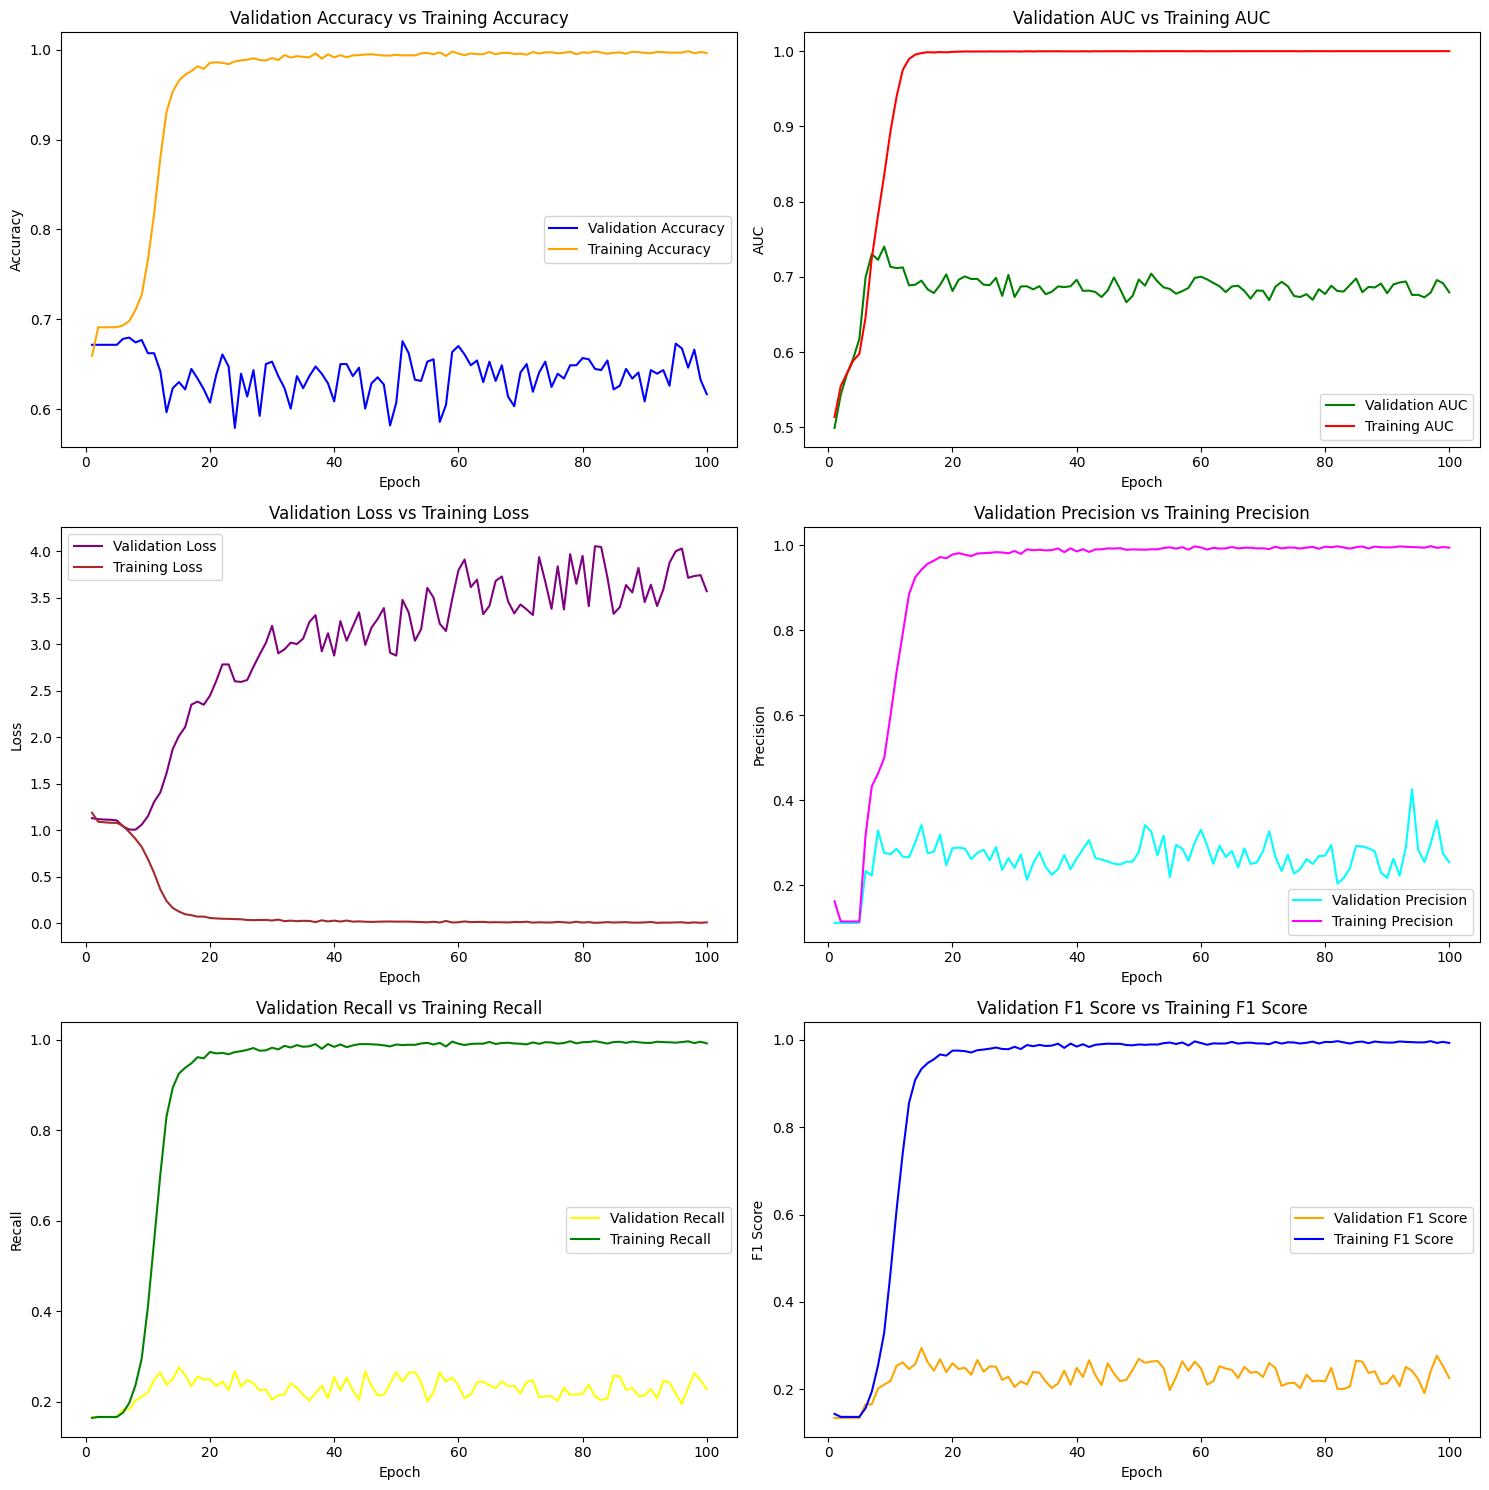

In [29]:
import pandas as pd
import matplotlib.pyplot as plt


# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot accuracy
axes[0, 0].plot(history['epoch_number'], history['val_accuracy'], label='Validation Accuracy', color='blue')
axes[0, 0].plot(history['epoch_number'], history['train_accuracy'], label='Training Accuracy', color='orange')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Validation Accuracy vs Training Accuracy')
axes[0, 0].legend()

# Plot AUC
axes[0, 1].plot(history['epoch_number'], history['val_auc'], label='Validation AUC', color='green')
axes[0, 1].plot(history['epoch_number'], history['train_auc'], label='Training AUC', color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Validation AUC vs Training AUC')
axes[0, 1].legend()

# Plot loss
axes[1, 0].plot(history['epoch_number'], history['val_loss'], label='Validation Loss', color='purple')
axes[1, 0].plot(history['epoch_number'], history['train_loss'], label='Training Loss', color='brown')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Validation Loss vs Training Loss')
axes[1, 0].legend()

# Plot precision
axes[1, 1].plot(history['epoch_number'], history['val_precision'], label='Validation Precision', color='cyan')
axes[1, 1].plot(history['epoch_number'], history['train_precision'], label='Training Precision', color='magenta')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Validation Precision vs Training Precision')
axes[1, 1].legend()

# Plot recall
axes[2, 0].plot(history['epoch_number'], history['val_recall'], label='Validation Recall', color='yellow')
axes[2, 0].plot(history['epoch_number'], history['train_recall'], label='Training Recall', color='green')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Recall')
axes[2, 0].set_title('Validation Recall vs Training Recall')
axes[2, 0].legend()

# Plot F1 score
axes[2, 1].plot(history['epoch_number'], history['val_f1'], label='Validation F1 Score', color='orange')
axes[2, 1].plot(history['epoch_number'], history['train_f1'], label='Training F1 Score', color='blue')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('F1 Score')
axes[2, 1].set_title('Validation F1 Score vs Training F1 Score')
axes[2, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [30]:
model_path = '/kaggle/working/best_model_precision.pth'
# model_path = '/kaggle/input/20-03-2024-vinbigdata-multilabel-weights/best_model_auc.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [31]:
test_scores_all = []
test_labels_all = []
test_predictions_all = []

correct_test = 0
total_test = 0


# Don't need to keep track of gradients
with torch.no_grad():
    # Set to evaluation mode
    model.eval()

    start = timer()
    #Test loop
    for batch_data in tqdm(test_loader):
        inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  

        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.long()


        scores = torch.softmax(outputs, dim=1) # to get multiclass probabilites
        _, predictions = torch.max(outputs, 1) # the predicted single class index
        total_test += labels.size(0)

        correct_test += (predictions == labels).sum().item()

        test_scores_all.extend(scores.detach().cpu().numpy())
        test_labels_all.extend(labels.cpu().numpy())
        test_predictions_all.extend(predictions.cpu().numpy())

    accuracy_test = correct_test / total_test

    print(f"Accuracy: {accuracy_test:.4f}")
    print("correct:", correct_test, " out of ", total_test)

    test_predictions_all = np.array(test_predictions_all).astype(float)
    test_labels_all = np.array(test_labels_all).astype(float)

    print(classification_report(test_labels_all, test_predictions_all, target_names=diseases)) 
    # adjust the target_names


    cm = confusion_matrix(test_labels_all, test_predictions_all) # for multi-class classification
    print(f"confusion matrix:", cm)

    # Compute accuracy
    accuracy_macro_test = accuracy_score(test_labels_all, test_predictions_all)

    # Compute precision, recall, and F1-score for each class
    precision_arr = precision_score(test_labels_all, test_predictions_all, average=None)
    recall_arr = recall_score(test_labels_all, test_predictions_all, average=None)
    f1_arr = f1_score(test_labels_all, test_predictions_all, average=None)

    precision_arr = np.nan_to_num(precision_arr, nan=0)
    recall_arr = np.nan_to_num(recall_arr, nan=0)
    f1_arr = np.nan_to_num(f1_arr, nan=0)

    # we will use macro-averaging strategy.
    precision_macro_test = round(sum(precision_arr) / len(precision_arr), 4)
    recall_macro_test = round(sum(recall_arr) / len(recall_arr), 4)
    f1_macro_test = round(sum(f1_arr) / len(f1_arr), 4)

    # Convert labels to binary form (one-hot encoding)
    lb = LabelBinarizer()
    test_labels_one_hot = lb.fit_transform(test_labels_all)
#     print(f"one hot labels: {test_labels_one_hot}")
#     print(f"actual labels: {test_labels_all}")

    roc_auc_macro_test = round(roc_auc_score(test_labels_one_hot, test_scores_all, average='macro'), 4)
        
    print("MACRO-averged metrics", end=':- ')
    print(f"accuracy: {accuracy_macro_test}, precision: {precision_macro_test}", end=', ')
    print(f"recall: {recall_macro_test}, f1: {f1_macro_test}, ROC_AUC: {roc_auc_macro_test}")

    infer_time = timer()-start
    print(f"INFERENCE TIME: {(infer_time):.4f} seconds")
    print("-"*120)

100%|██████████| 169/169 [00:20<00:00,  8.38it/s]

Accuracy: 0.6247
correct: 844  out of  1351
                  precision    recall  f1-score   support

      No finding       0.73      0.88      0.80       907
      Bronchitis       0.33      0.11      0.16       155
Brocho-pneumonia       0.19      0.11      0.14        61
   Other disease       0.00      0.00      0.00        70
   Bronchiolitis       0.12      0.22      0.15        81
       Pneumonia       0.35      0.09      0.14        77

        accuracy                           0.62      1351
       macro avg       0.29      0.24      0.23      1351
    weighted avg       0.56      0.62      0.58      1351

confusion matrix: [[795  23  11   0  76   2]
 [108  17   7   0  17   6]
 [ 27   6   7   0  18   3]
 [ 54   3   3   0   8   2]
 [ 59   2   2   0  18   0]
 [ 46   1   6   1  16   7]]
MACRO-averged metrics:- accuracy: 0.6247224278312361, precision: 0.2865, recall: 0.2357, f1: 0.2339, ROC_AUC: 0.661
INFERENCE TIME: 20.1918 seconds
--------------------------------------------